<font color = 'blue'>
Content: 

1. [Load Python Pakages](#1)
2. [First look to data](#2)
3. [Data Cleaning (Missing value removal)](#3)
4. [Descriptive statistics](#4)   
5. [Exploratory Data Analysis](#5)   
6. [Preprocessing](#6)
7. [Splitting data to train and test sets (Perform adversarial validation)](#7)
8. [Modeling and hyperparameter tuning](#8)
9. [Step 1: Train a base model with all features (LightGBM + SMOTE)](#9)
10. [Step 2: Feature Selection Based on Model's Importance Scores](#10)
11. [Step 3: Hyperparameter tunning with selected features](#11)  
12. [Explainable ML with SHAP](#12) 

<a id = "1"></a><br>
# Load Python Pakages


In [1195]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


#feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel

#transformers and pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB


#model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,  f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer


# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler

# Dealing with imbalanced target
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

random_state = 10


<a id = "2"></a><br>
#  First look to data

In [1268]:
# Read the data
original_train_df = pd.read_excel("C:\\Users\\Rıza\\Desktop\\evrim\\midus_data_evrim.xls")

# reserved 
pipe_data = original_train_df.copy()

# use for analysis
train_df = original_train_df.copy()
train_df.head()

HgbA1c  Total cholesterol  triglycerides    HDL  Total cholesterol/HDL  \
0  5.8622              197.0           71.0  111.0               1.774775   
1  7.4000              202.0          290.0   38.0               5.315789   
2  6.3000              192.0          108.0   52.0               3.692308   
3  5.4824              149.0          270.0   28.0               5.321429   
4  5.6000              226.0          213.0   35.0               6.457143   

     LDL  Creatinine  DHEA-S  DHEA  Glucose  ...  Lycopene  Gamma tocopherol  \
0   72.0         0.7    90.0   5.0     86.0  ...    0.2247              7.23   
1  106.0         0.9   145.0   4.3     94.0  ...    0.2588              2.95   
2  118.0         0.9    76.0   3.1     72.0  ...    0.1176              1.62   
3   67.0         0.7   150.0  12.9     76.0  ...    0.1177              1.81   
4  148.0         1.1   181.0   6.9    152.0  ...    0.2152              5.22   

   Alpha tocoperol  Retinol  n-Telopeptide type 1 collagen  \
0            32.25     1.33                          17.74   
1            25.46     2.03                          14.75   
2            35.89     1.83                          18.76   
3            81.68     1.70                          12.59   
4            19.69     1.42                          10.55   

   Bone specific alkaline phosphatase  \
0                               46.73   
1                               50.18   
2                               52.99   
3                               40.86   
4                               35.86   

   Amino terminal propeptide type 1 procollagen  Age  Sex  Gait speed  
0                                         47.99   44    2    1.385455  
1                                        115.68   59    2    0.743415  
2                                         30.65   60    2    1.016000  
3                                         37.18   53    1    0.762000  
4                                         48.28   55    2    0.870857  

[5 rows x 36 columns]

In [1269]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 36 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   HgbA1c                                        1235 non-null   float64
 1   Total cholesterol                             1244 non-null   float64
 2   triglycerides                                 1243 non-null   float64
 3   HDL                                           1242 non-null   float64
 4   Total cholesterol/HDL                         1242 non-null   float64
 5   LDL                                           1242 non-null   float64
 6   Creatinine                                    1244 non-null   float64
 7   DHEA-S                                        1239 non-null   float64
 8   DHEA                                          1240 non-null   float64
 9   Glucose                                       1236 non-null   f

In [1270]:
#An important decision: Include only Age and Sex along with blood sample measurements.
#Other sample chracteristics and redundant features are exculuded
#train_df = train_df.drop(['BMI','Education','PA level','WHR','Serum IL6 (pg/mL)','Serum Soluble IL6 Receptor (pg/mL)'], axis=1)

#correct column name
train_df.rename(columns={'HgbA1c': 'HgA1c'}, inplace=True)

#Important decision 2: Analysis include only elderly people 
train_df = train_df[train_df['Age']>= 60]
train_df.shape

(405, 36)

<a id = "3"></a><br>
## Data Cleaning (Missing value handling)

Lets check and visualize missing values.

In [1271]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

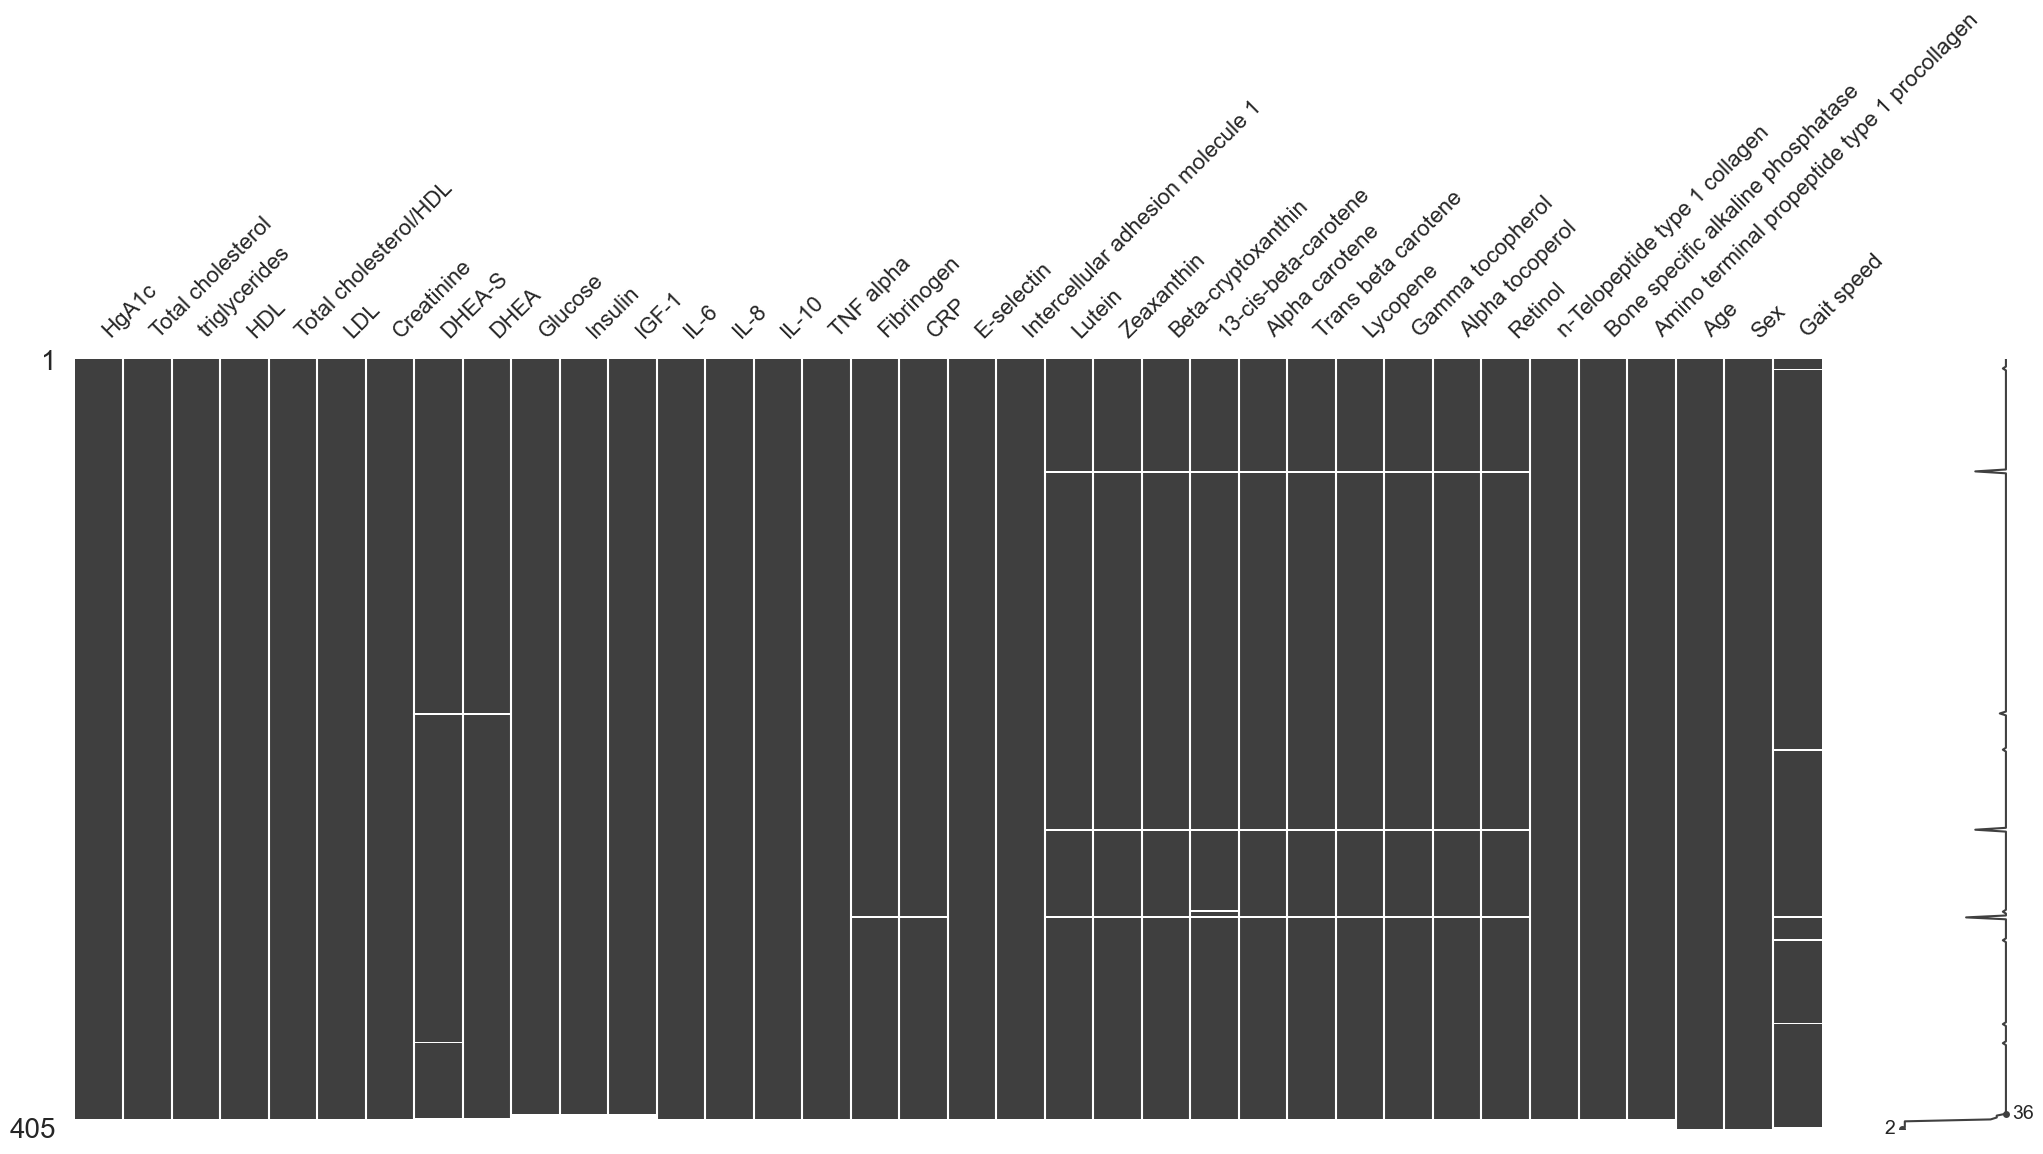

In [1272]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

I will drop missing values on Gait speed since it will be our target.

In [1273]:
train_df = train_df.dropna(subset=['Gait speed'])

Let's observe missing values again.

In [1274]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

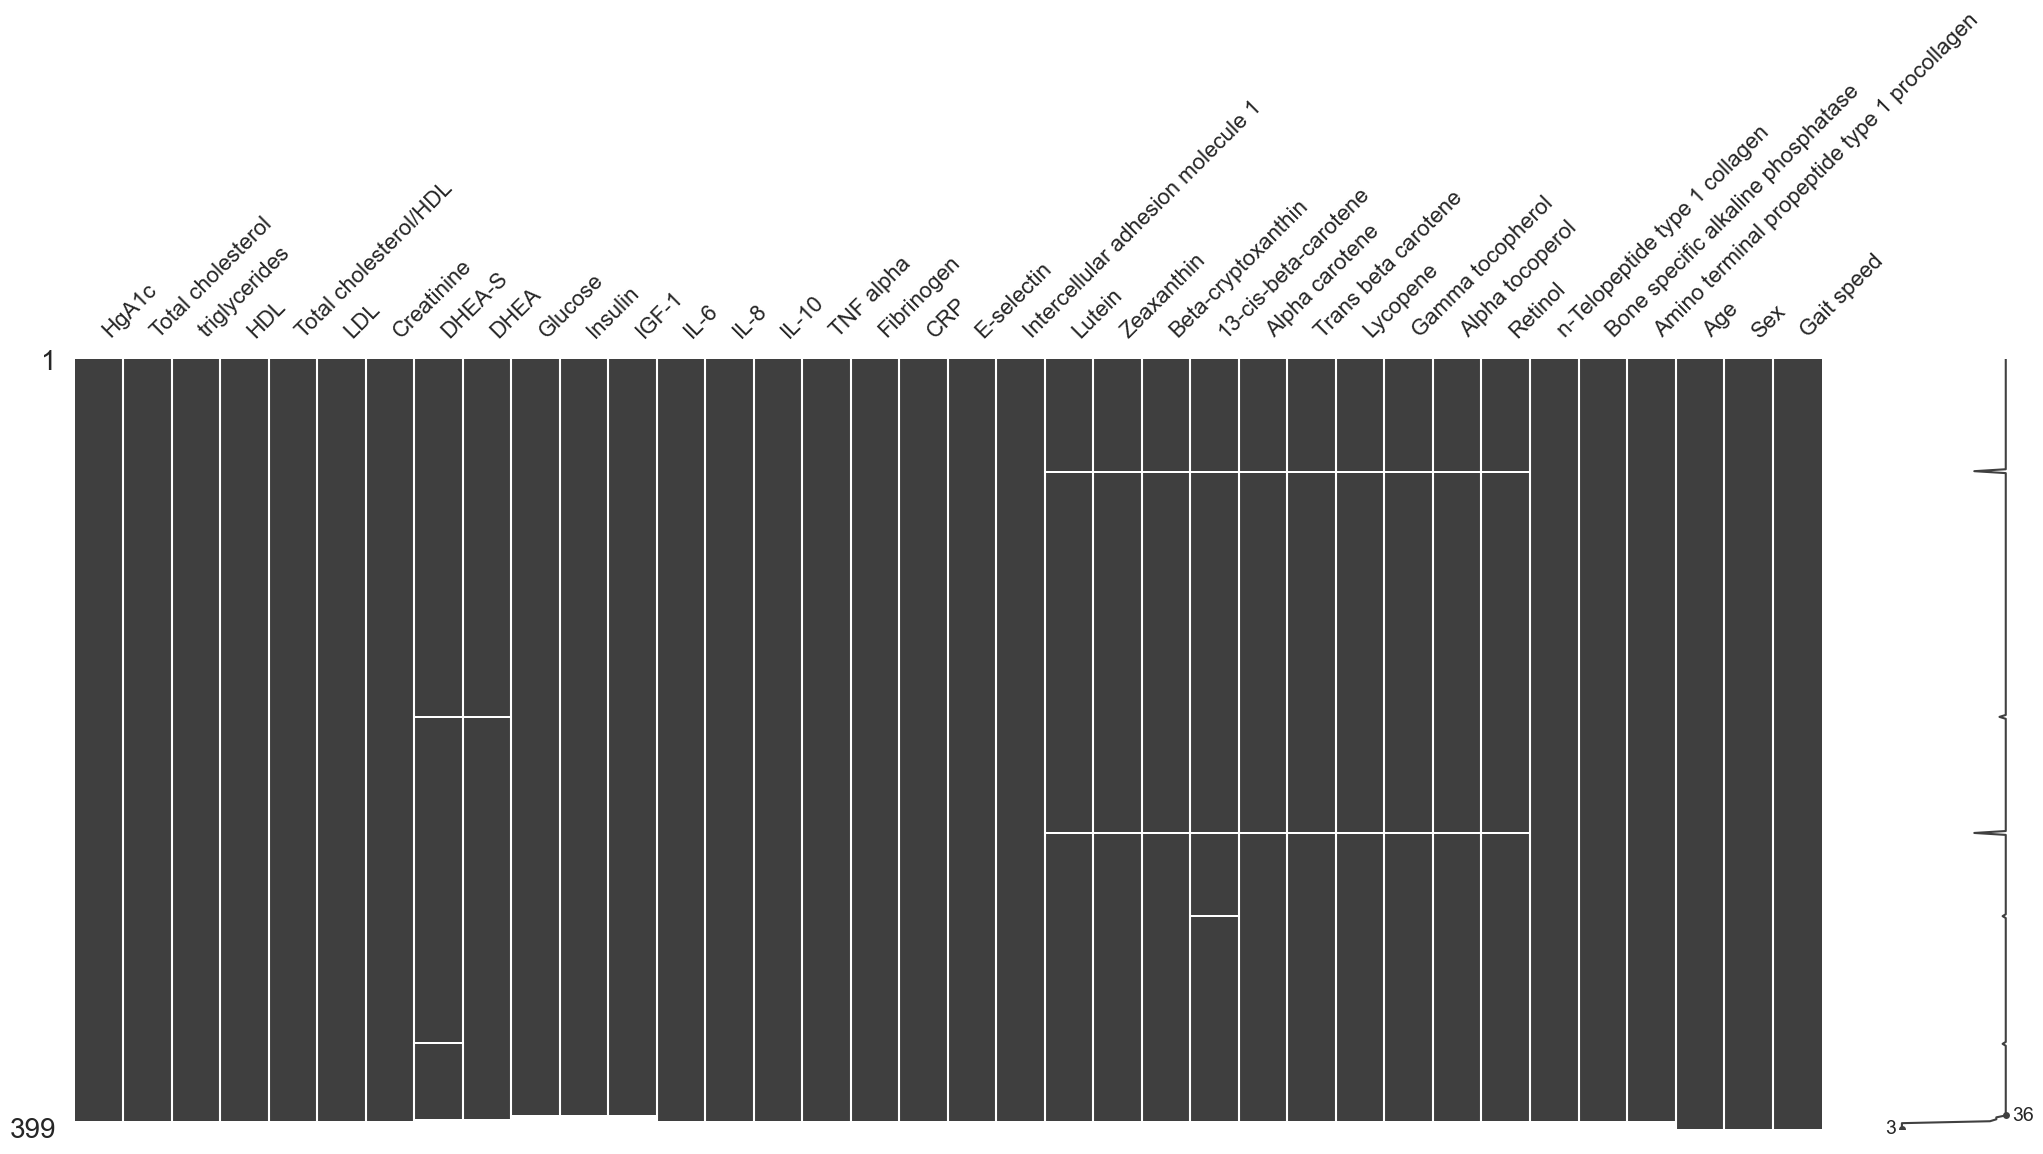

In [1275]:
msno.matrix(train_df)
plt.show()

In [1276]:
missing_rows_count = train_df.isnull().any(axis=1).sum()

print("Total rows with missing values:", missing_rows_count)

Total rows with missing values: 12


We have 399 samples that has gait speed information. This will be the final data that we will use for analysis & modelling.


There are 12 observations that include missing values. I will apply mean imputation for the missing values in modelling phase.


<a id = "4"></a><br>
## Descriptive statistics

Let's report basic descriptive statistics for data.

In [1277]:
#descriptive statistics
train_df.describe().T

count        mean         std  \
HgA1c                                         395.0    6.228691    0.957446   
Total cholesterol                             395.0  179.964557   40.590736   
triglycerides                                 395.0  124.992405   69.865007   
HDL                                           395.0   55.600000   17.204710   
Total cholesterol/HDL                         395.0    3.490188    1.206184   
LDL                                           395.0   99.400000   35.083034   
Creatinine                                    395.0    0.834430    0.202971   
DHEA-S                                        392.0  106.272959   72.843275   
DHEA                                          393.0    6.061089    4.089507   
Glucose                                       392.0  101.696429   26.586099   
Insulin                                       392.0   12.589286   10.062322   
IGF-1                                         392.0  125.454082   49.518479   
IL-6                                          395.0    1.267139    1.214476   
IL-8                                          395.0   15.938987   13.573989   
IL-10                                         395.0    0.474886    2.279680   
TNF alpha                                     395.0    2.443747    0.946566   
Fibrinogen                                    395.0  361.050633   91.543629   
CRP                                           395.0    2.796807    4.272309   
E-selectin                                    395.0   39.901089   18.820551   
Intercellular adhesion molecule 1             395.0  303.284456  106.478817   
Lutein                                        393.0    0.320529    0.217711   
Zeaxanthin                                    393.0    0.068958    0.046197   
Beta-cryptoxanthin                            393.0    0.218787    0.194538   
13-cis-beta-carotene                          392.0    0.080794    0.077477   
Alpha carotene                                393.0    0.095572    0.120648   
Trans beta carotene                           393.0    0.713740    0.889518   
Lycopene                                      393.0    0.422764    0.235637   
Gamma tocopherol                              393.0    3.282850    2.559660   
Alpha tocoperol                               393.0   31.394555   12.925956   
Retinol                                       393.0    1.916107    0.705643   
n-Telopeptide type 1 collagen                 395.0   14.390506    7.028894   
Bone specific alkaline phosphatase            395.0   28.168000   12.022478   
Amino terminal propeptide type 1 procollagen  395.0   54.471013   28.149825   
Age                                           399.0   68.260652    6.431098   
Sex                                           399.0    1.533835    0.499480   
Gait speed                                    399.0    0.988025    0.235064   

                                                     min         25%  \
HgA1c                                           4.000000    5.735600   
Total cholesterol                              91.000000  150.000000   
triglycerides                                  37.000000   80.000000   
HDL                                            19.000000   43.500000   
Total cholesterol/HDL                           1.338235    2.648309   
LDL                                            16.000000   74.000000   
Creatinine                                      0.500000    0.700000   
DHEA-S                                          2.000000   54.000000   
DHEA                                            0.400000    3.100000   
Glucose                                         5.000000   90.000000   
Insulin                                         1.000000    6.000000   
IGF-1                                          29.000000   90.000000   
IL-6                                            0.190000    0.700000   
IL-8                                            4.960000   10.590000   
IL-10                                     

Let's also observe target variable (Gate Speed) 

<Axes: xlabel='Gait speed', ylabel='Count'>

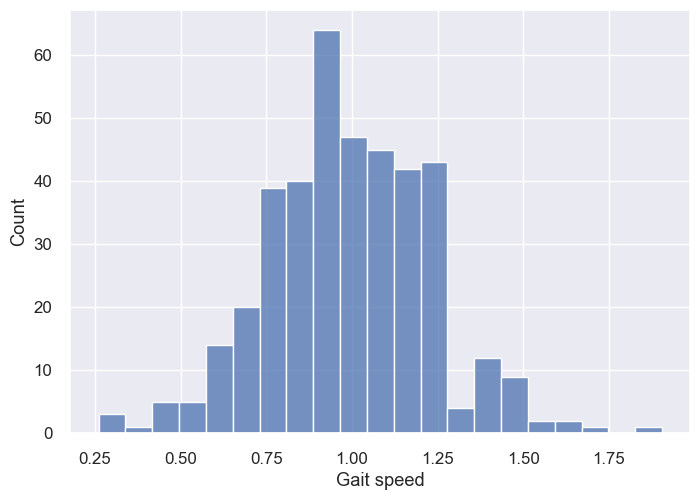

In [1278]:
 sns.histplot(x='Gait speed',  data=train_df )

We will discretize the target (Gait speed) as below 0.8 and above 0.8 and follow a classification approach. 
This is an important decision. The justification of this decision comes from the fact that a Gait speed 0.8 is a critical threshold for fall risk. And it has a huge meaning from a clinical perspective. 

* Class 1 indicates below-0.8 (observations that has a fall risk)
* Class 0 indicated above-0.8 (observations that has a normal Gait speed)

In [1279]:
# Gait speed is mapped to 0 and 1. 1 indicates samples has a Gait speed below 0.8 m / s
train_df['Gait speed'] = (train_df['Gait speed'] < 0.8 ).astype(int)

In [1280]:
train_df['Gait speed'].value_counts()

0    326
1     73
Name: Gait speed, dtype: int64

We have 73 samples belonging class 1 and 326 samples class 0

Let's make a visualization for class distribution.

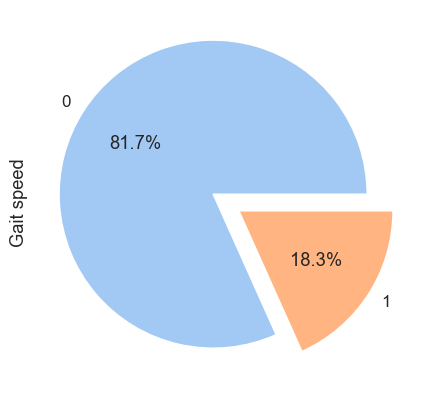

In [1281]:
#Target Distribution plot
plt.figure(figsize=(5,5))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('Gait speed')['Gait speed'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");

81.7% of samples are above 0.8. 18.3% of samples are below 0.8. 

Target variable distribution is quite imbalanced. At the modeling stage, the Synthetic Minority Over-sampling Technique (SMOTE) and class_weight adjustment are used to deal with this imbalance distribution. SMOTE performed better, this notebook includes only SMOTE version of the work.

Due to imbalanced nature of the data F1 score is used as an optimization metric. 

F1 score is defined as the harmonic mean of precision and recall.

<a id = "5"></a><br>
# Exploratory Data Analysis

On this part we will explore relationship beetween target and features. 
This part includes:

* Some visualization 
* Reporting mutual information scores for features with respect to target
* And a correlation matrix between features

In [1282]:
train_df.nunique().sort_values()

Gait speed                                        2
Sex                                               2
Creatinine                                       14
Age                                              25
Insulin                                          44
HDL                                              74
IL-10                                            79
Glucose                                          80
HgA1c                                            86
LDL                                             132
Total cholesterol                               155
DHEA                                            162
IGF-1                                           167
triglycerides                                   170
IL-6                                            182
Retinol                                         183
DHEA-S                                          189
TNF alpha                                       199
Fibrinogen                                      221
Gamma tocoph

In [1283]:
# Store continuous and discrete features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Gait speed"]

discrete_features = [ 'Sex']

continuous_features = list(set(feature_list) - set(discrete_features))

assert feature_list.sort() == (discrete_features + continuous_features).sort()


Let's observe features with respect to target.

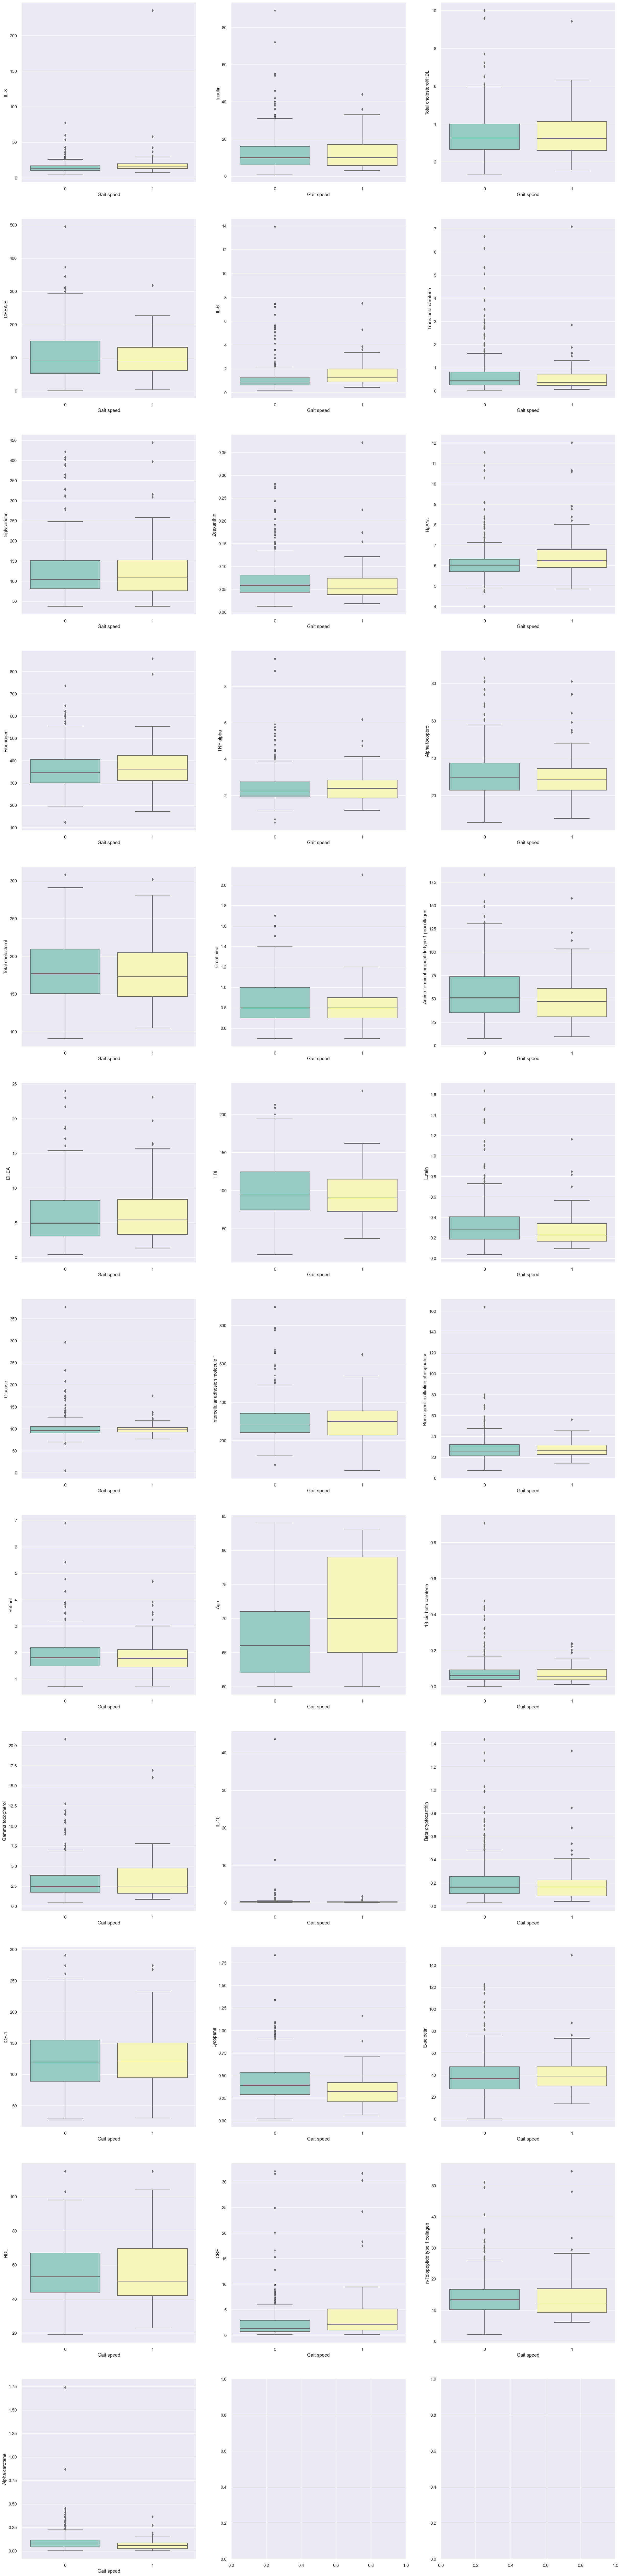

In [1284]:
#Box-plots
fig, ax = plt.subplots(12, 3, figsize=(30, 130))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Gait speed', y=var, data=train_df, ax=subplot, palette='Set3')

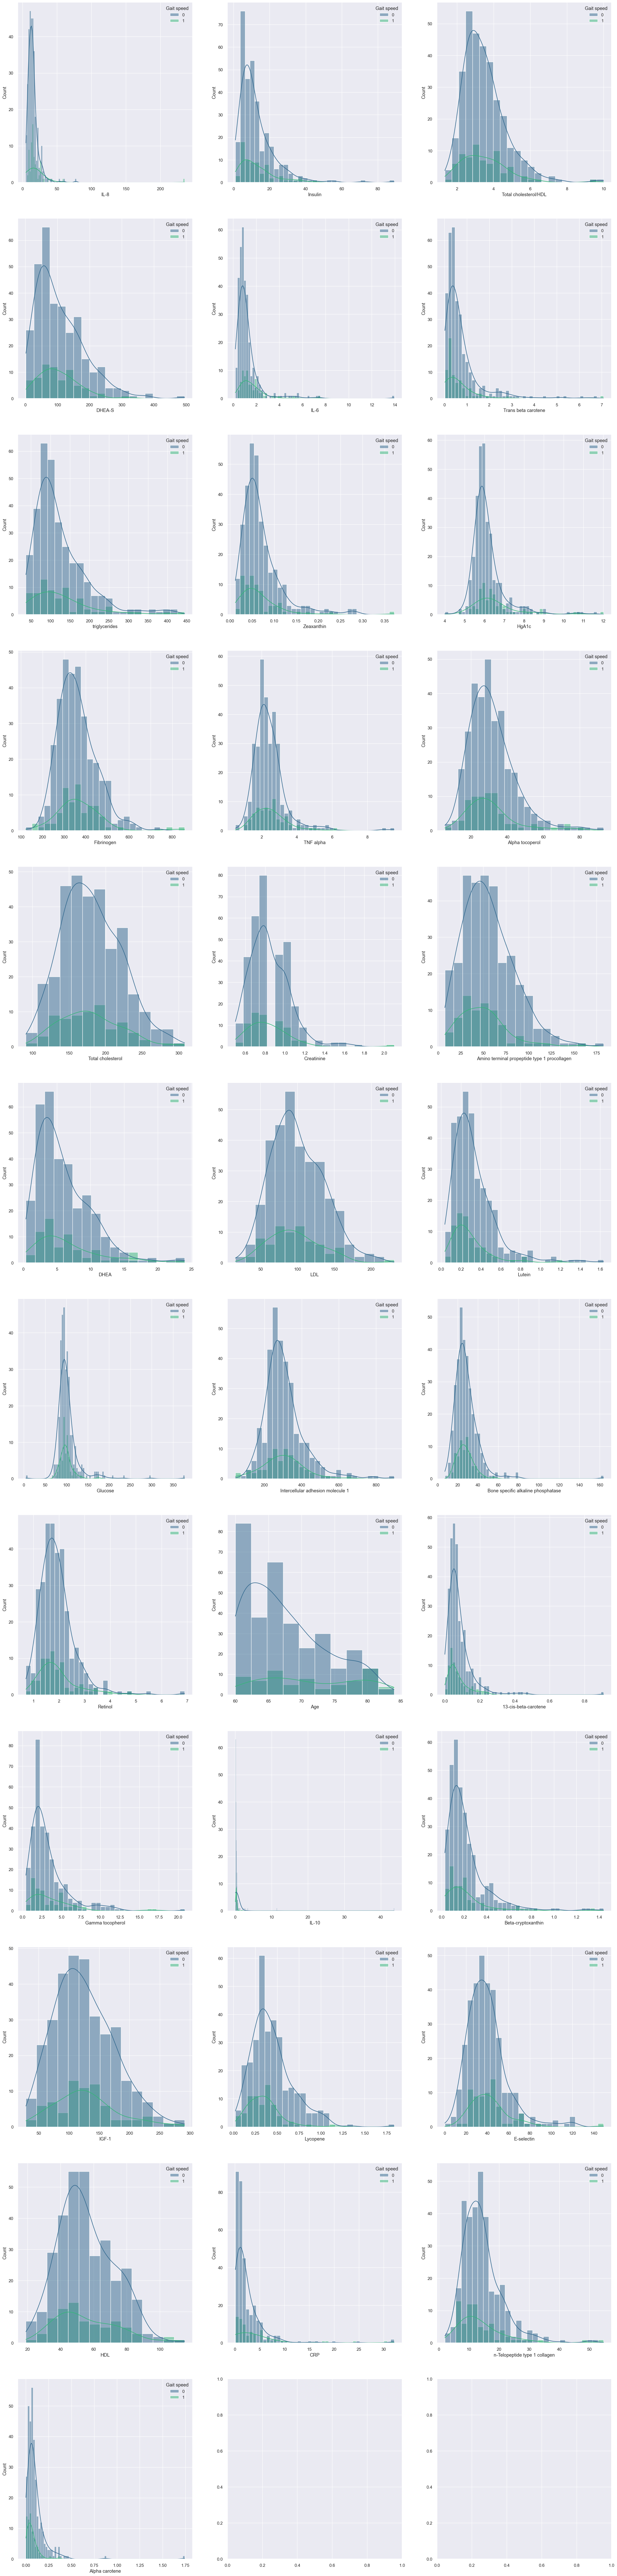

In [1285]:
#Histograms
fig, ax = plt.subplots(12, 3, figsize=(30, 130))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.histplot(x=var,  data=train_df, ax=subplot, hue='Gait speed', kde=True ,  palette='viridis')

<Axes: xlabel='Sex', ylabel='Gait speed'>

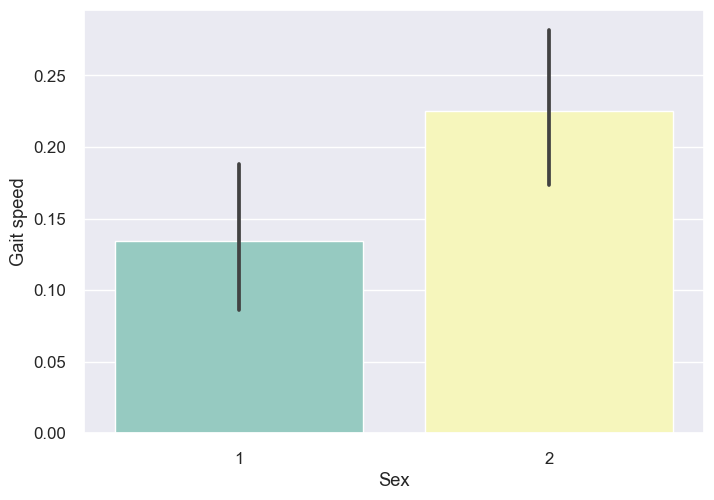

In [1286]:
sns.barplot(x='Sex', y= 'Gait speed', data=train_df, palette='Set3')

Let's look at the relationship between features and the target more quantitatively...

Correlation is not a good measure while measuring relations between features and target for classification problems. 

(It is good at measuring linear relations between continuous variables, but our target is discrete)

Let's check mutual information, which measures this kind of relationship well.

In [1287]:
y = train_df['Gait speed']

In [1288]:
# determine the mutual information for features
#we need to fill missing values to get results from mutual_info_classif function
mutual_df = train_df[feature_list ]

mutual_info = mutual_info_classif(mutual_df.fillna(mutual_df.mean()), y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")


In [1289]:
most_info_cols = mutual_info[mutual_info['Numerical_Feature_MI'] > 0.012].index.values.tolist()

Let's make one more visualization which shows a pair plot that includes only features with highest mutual information score. 

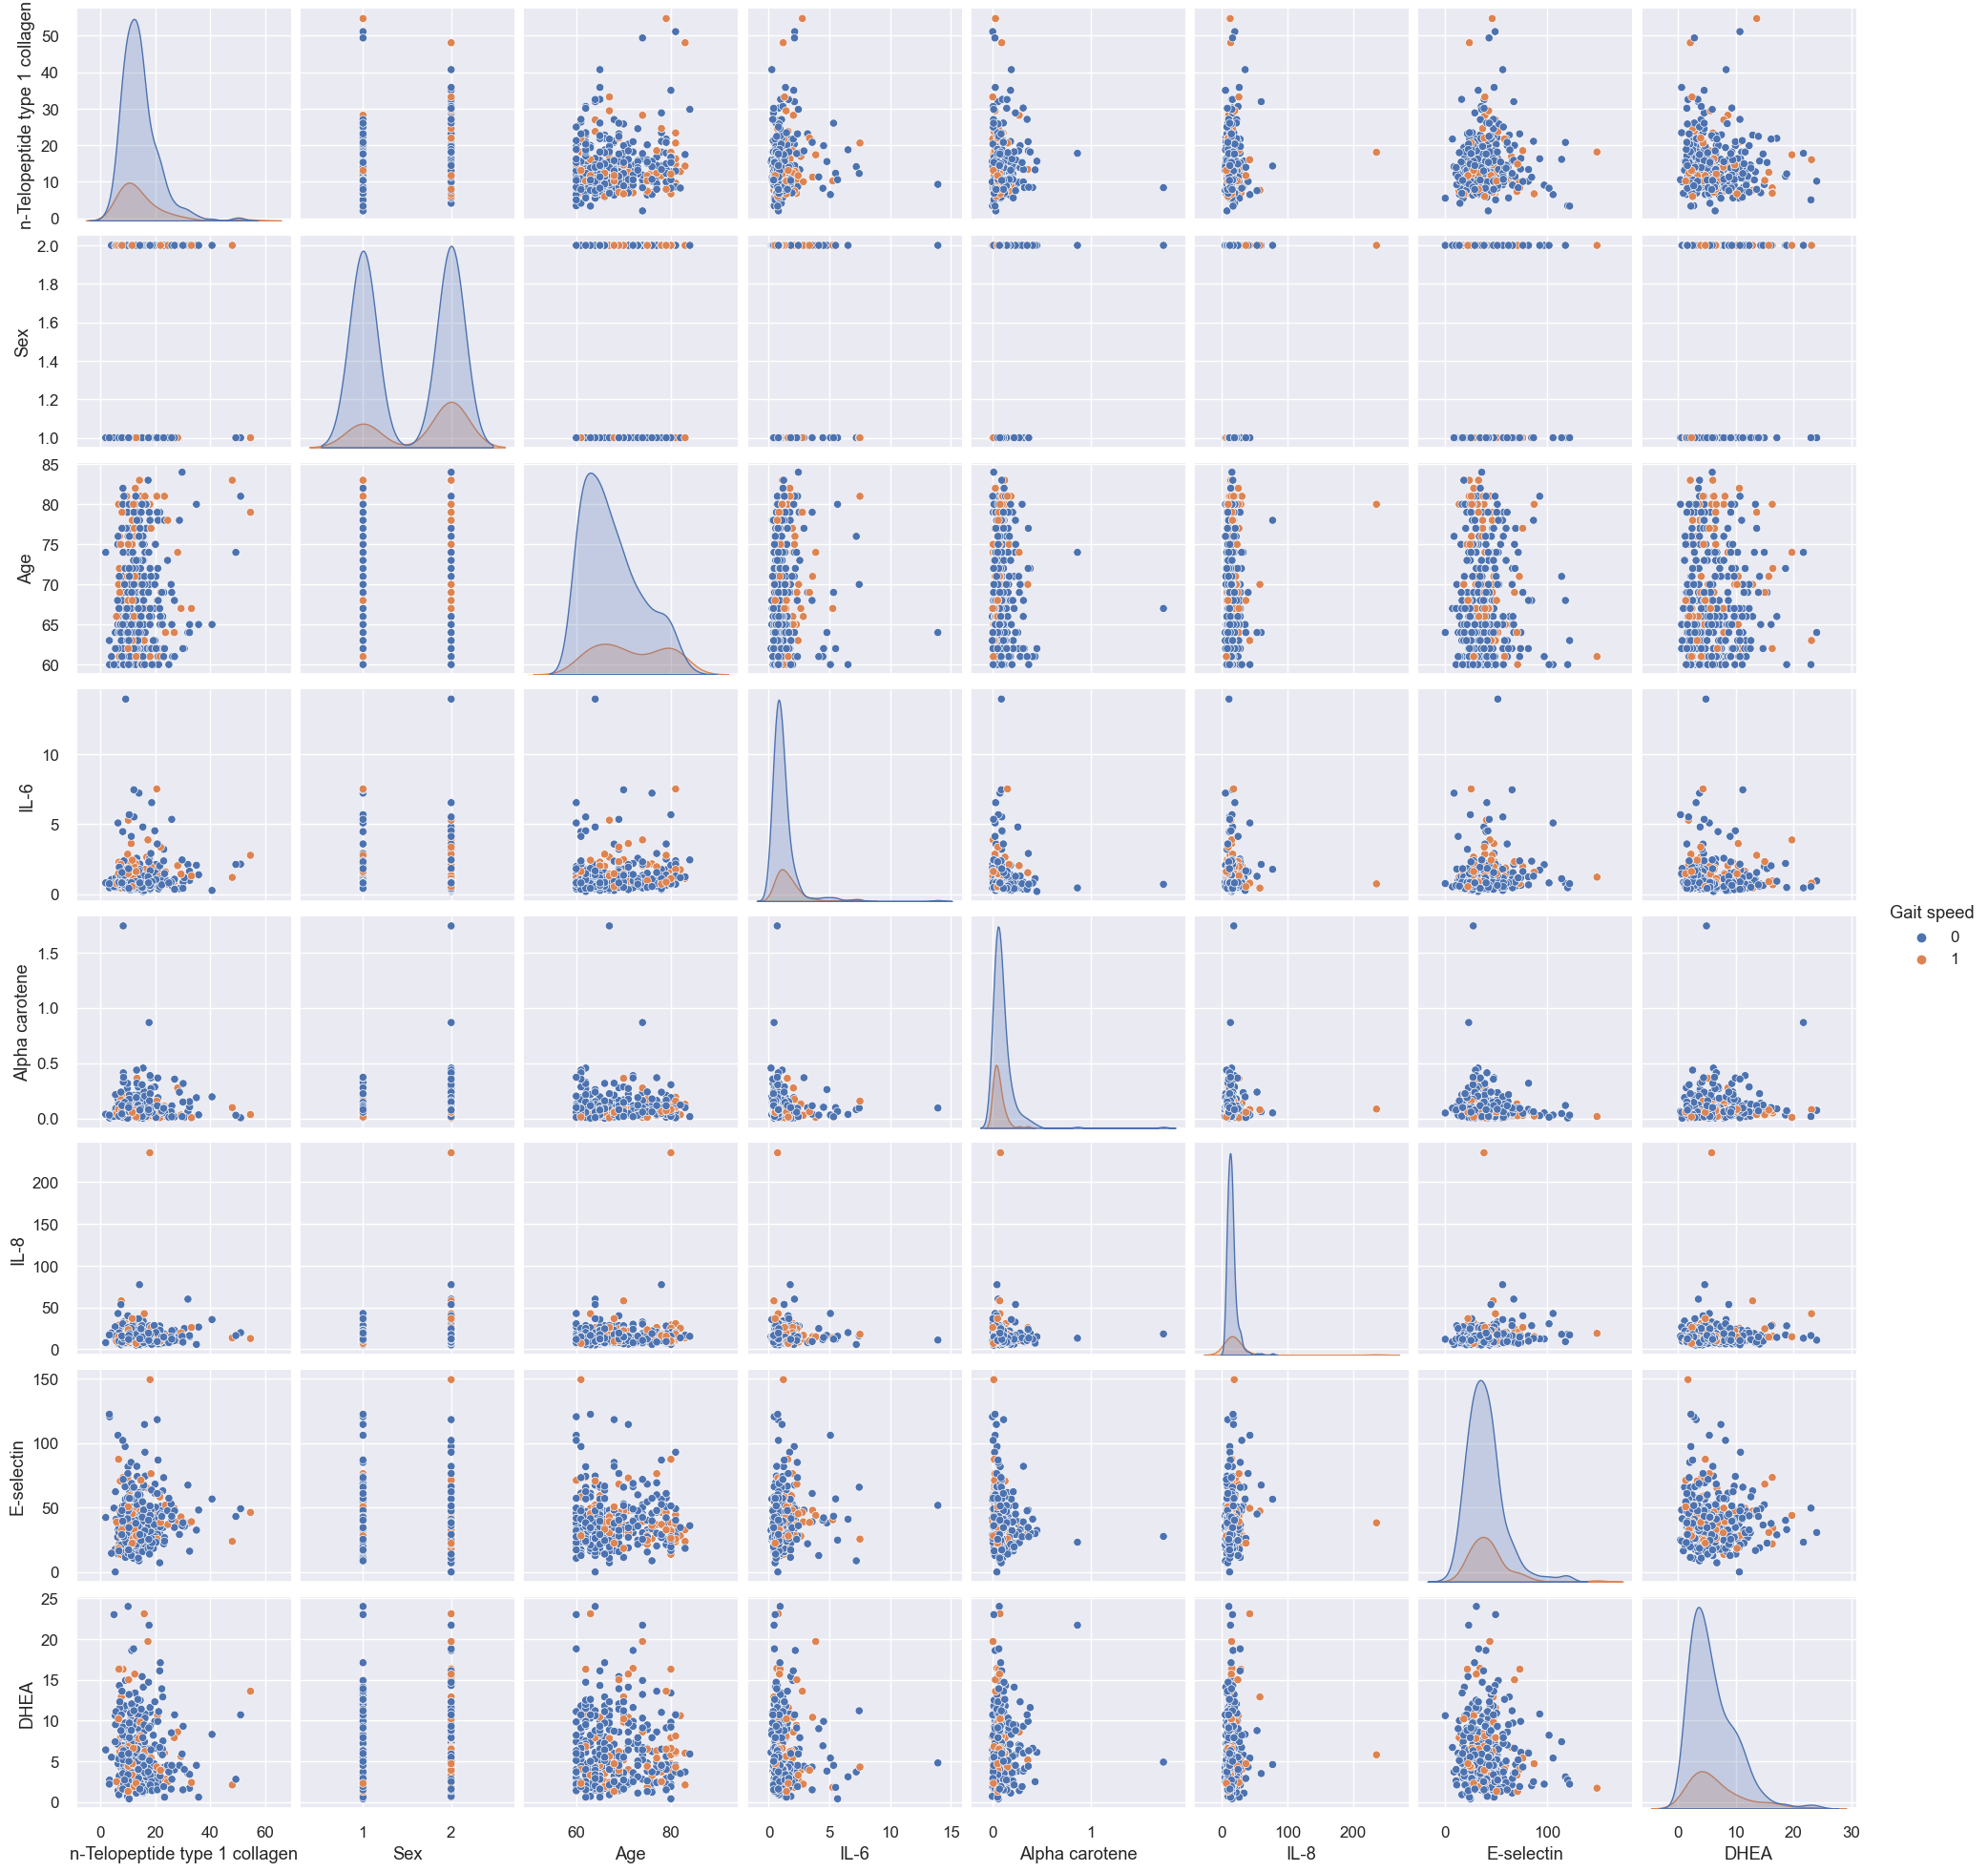

In [1290]:
#pair-plot for most important features
sns.pairplot(train_df[most_info_cols + ["Gait speed"]], hue="Gait speed")

Lastly I will report correlations between features. Note that correlation is not a good measure for target.I will only report it for reference.

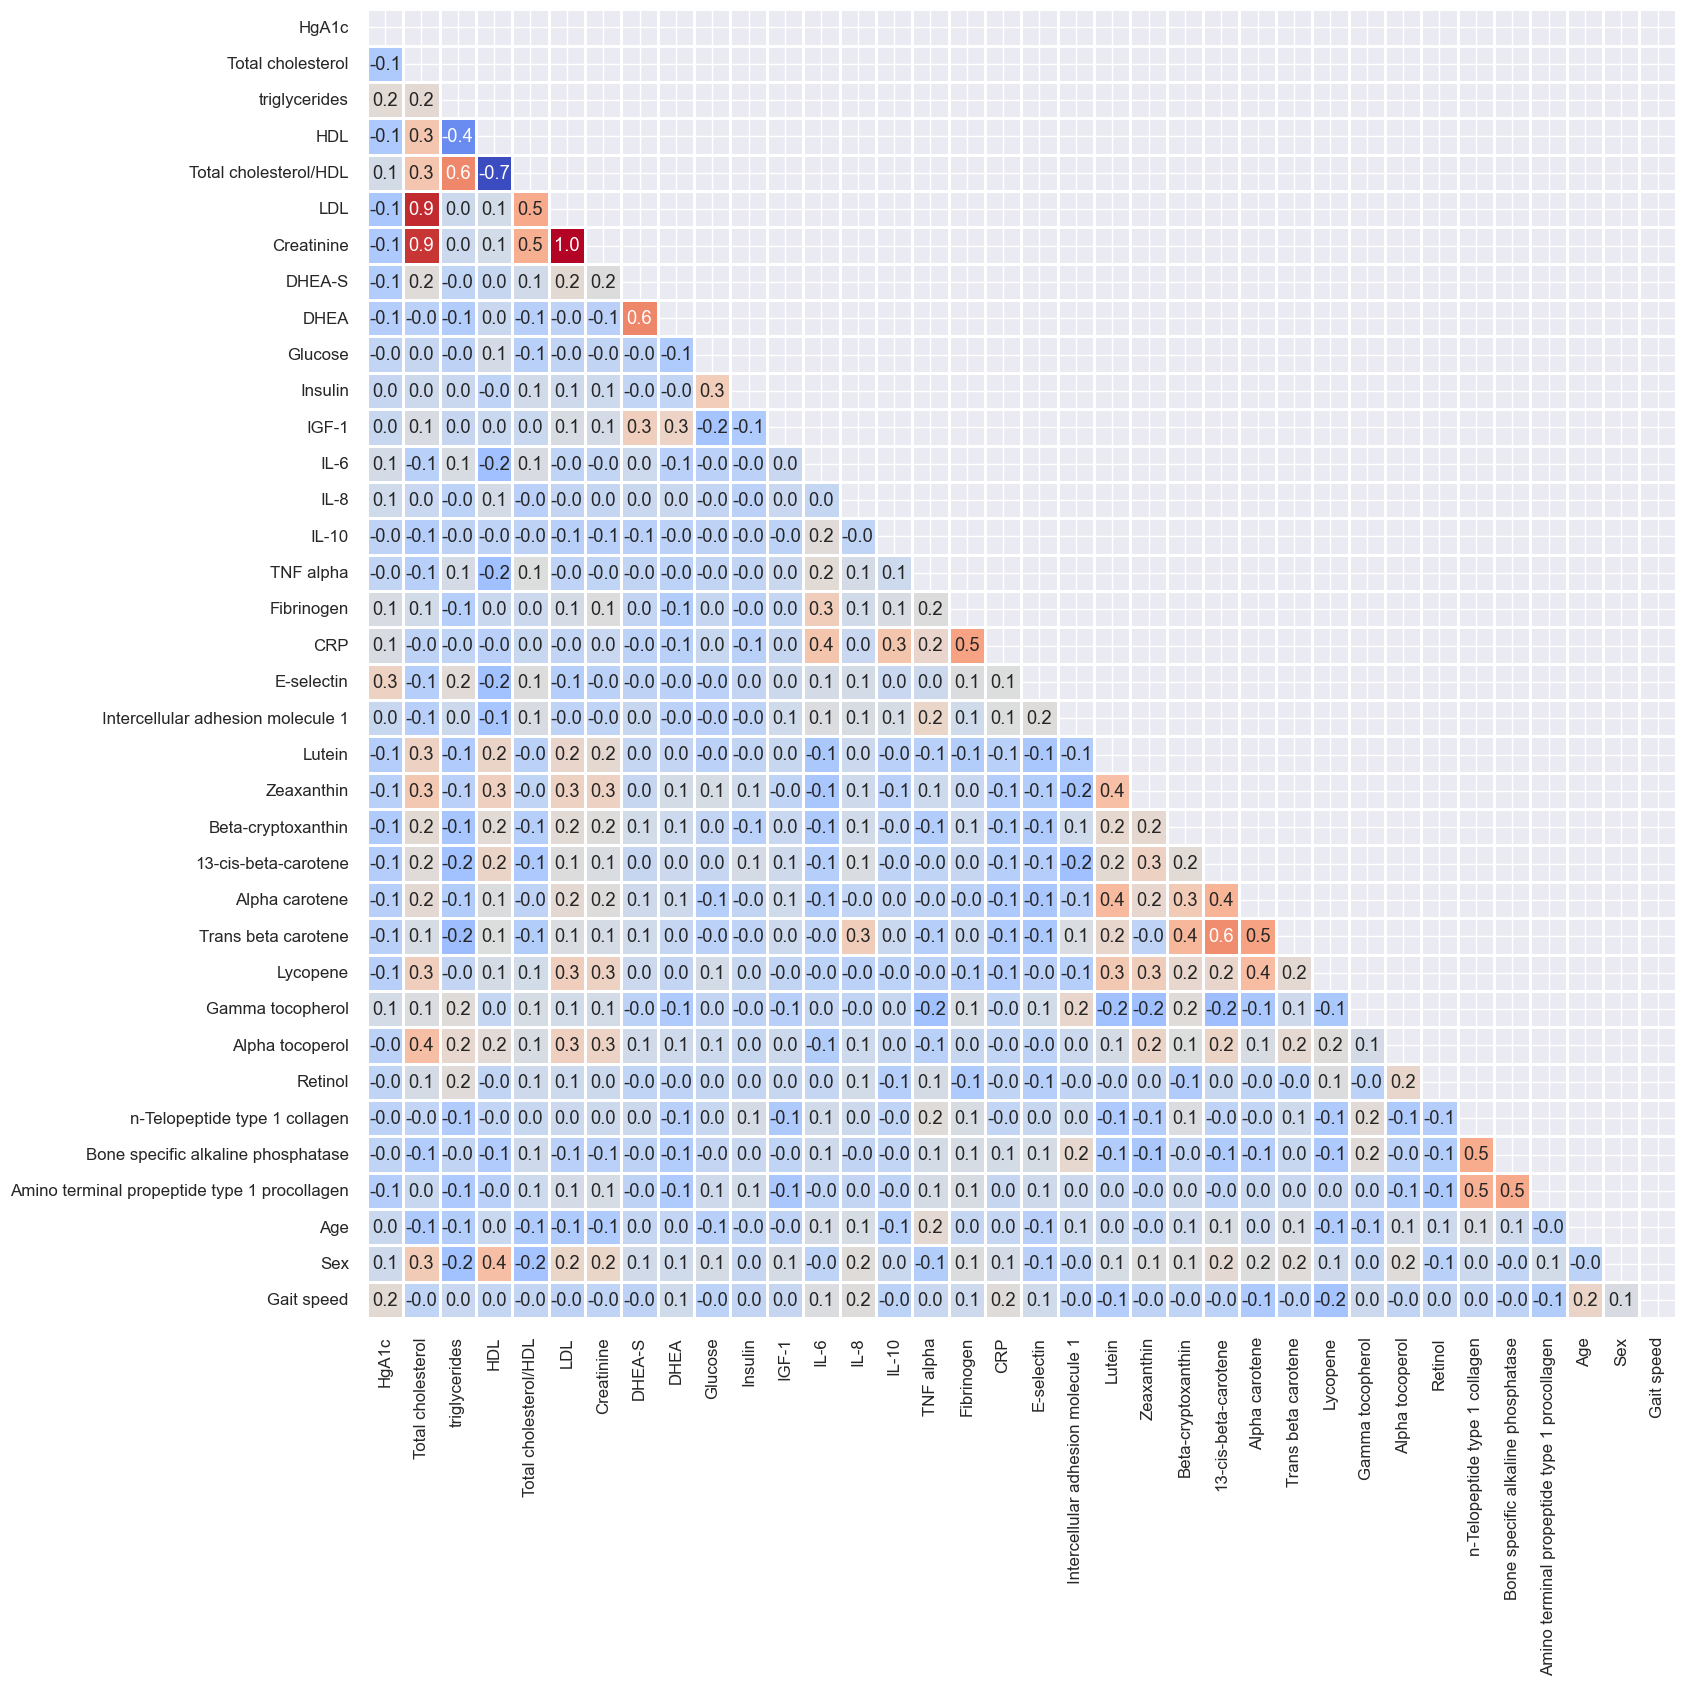

In [1291]:
# Display correlations between numerical features

sns.set(font_scale=1.1)
correlation_train = train_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

<a id = "6"></a><br>
## Preprocessing

I will use tree-based boosting methods(LightGBM and XGBoost). This medhods do not require extensive preprocessing unlike linear and distance based algorithms or neural networks.

We will need only a simple imputer object for missing value imputation.
Another thing we will need is SMOTE to straggle unbalance class distribution.

In [1292]:
#for imputing missing values
preprocessor = SimpleImputer(strategy='mean')

#SMOTE for oversampling of minority class(class 1)
sm = SMOTE(random_state=random_state)

<a id = "7"></a><br>
## Splitting data to train and test sets (Perform adversarial validation)

Before moving to the modeling phase, I will create train and test splits.

Getting stable models on small datasets is often challenging. Ensuring that the training and test data distributions are similar is one of the key issues to obtain stable models.

To ensure that the distributions of the training and test data are similar, we will employ adversarial validation.

Adversarial validation is a simple technique that assesses how similar the distributions of the training and test datasets are. It involves creating a combined dataset and training a classifier to distinguish between the training and test examples based on their features. If the classifier struggles to differentiate between the two datasets, it indicates that their distributions are similar, which is crucial for building reliable models.

Typically, an AUC score around 0.5 indicates that the model struggles to differentiate between the train and test samples. This suggests that their distributions are similar, making it challenging for the model to distinguish between them.

To verify this, I will employ a Gaussian Naive Bayes (GaussianNB) model.


In [1293]:
#seperate target
y = train_df['Gait speed']
train_df = train_df.drop(['Gait speed'], axis=1)


In [1294]:
#create train-test split. 
X_train, X_test, y_train, y_test = train_test_split(train_df, y, 
                                                    test_size=0.2,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)


print(X_train.shape, X_test.shape)

(319, 35) (80, 35)


In [1295]:
adver_clf = Pipeline([
    
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ("GaussianNB", GaussianNB())
])

In [1296]:
def adversarial_validation(X_train, X_test):
    # Label train samples as 0 and test samples as 1
    y_train = np.zeros(X_train.shape[0])
    y_test = np.ones(X_test.shape[0])
    
    # Concatenate train and test data
    X_adv = np.concatenate([X_train, X_test], axis=0)
    y_adv = np.concatenate([y_train, y_test], axis=0)
    
    # Initialize cross-validation splitter
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
    
    auc_scores = []
    for train_index, val_index in cv.split(X_adv, y_adv):
        X_adv_train, X_adv_val = X_adv[train_index], X_adv[val_index]
        y_adv_train, y_adv_val = y_adv[train_index], y_adv[val_index]
        
        # Train a classifier
        clf =  adver_clf

        clf.fit(X_adv_train, y_adv_train)
        
        # Predict probabilities for the validation set
        y_adv_pred = clf.predict_proba(X_adv_val)[:, 1]
        
        # Calculate AUC-ROC score
        auc_score = roc_auc_score(y_adv_val, y_adv_pred)
        auc_scores.append(auc_score)
    
    avg_auc_score = np.mean(auc_scores)
    
    return avg_auc_score

avg_auc_score = adversarial_validation(X_train, X_test)
print("Average AUC-ROC Score for Adversarial Validation with Cross-Validation:", avg_auc_score)

Average AUC-ROC Score for Adversarial Validation with Cross-Validation: 0.49309740823412695


With an AUC score of 0.49, it suggests that our model struggles to effectively differentiate between the train and test samples, indicating similarity in the distributions of the training and test datasets. Based on this observation, we can proceed to the modeling phase.

<a id = "8"></a><br>
# Modeling and hyperparameter tuning

%80 of the data is used for training. %20 of the data is reserved as a test set for final model evaluation. 


Target variable distribution is quite imbalanced. At the modeling stage, the Synthetic Minority Over-sampling Technique (SMOTE) and class_weight adjustment are used to deal with this imbalance distribution. SMOTE performed better. This notebook includes only results with SMOTE. 

Boosting methods are generally performs better on tabular data. We tried XGBoost and LightGBM. XGBoost was the better performing one. This notebook only includes results of XGBoost algorithm.


Although accuracy is a default metric for most classification problems, it's generally misleading for imbalanced data sets. That is why the F1 score is used as an optimization metric. 

F1 score is defined as the harmonic mean of precision and recall.

![ ]( https://www.researchgate.net/publication/367393140/figure/fig4/AS:11431281114710300@1674648981676/Confusion-matrix-Precision-Recall-Accuracy-and-F1-score.jpg)


For model training a hyperparameter optimization with cross validation is performed.

Given the limited size of the dataset, a rigorous cross-validation approach was adopted to ensure reliable model evaluation. The selected method, RepeatedStratifiedKFold, was configured with parameters (n_splits=5, n_repeats=10, random_state=random_state). This approach divides the training data into 5 folds, ensuring that each class is represented proportionally within each fold, and repeats this process 10 times to enhance robustness.

During each iteration, the model is trained on 4 folds while the performance is evaluated on the remaining fold, known as the hold-out data. This process is repeated, with the hold-out fold changing in each iteration to ensure comprehensive evaluation. Furthermore, to address variability and ensure thorough evaluation, this entire process is repeated 10 times for each combination of hyperparameters before reporting the final evaluation metric. The final performance metric is calculated as the average score across all iterations.

For hyperparameter optimization OPTUNA package is used. OPTUNA is an open-source hyperparameter optimization framework based on Bayesian optimization, aimed at automating the tuning process of machine learning models.

Modelling phase has 3 consecutive steps:

* Step 1: Perform  hyperparameter optimization with cross validation  with using all features
* Step 2: Perform a  feature selection  based on models feature importance score with trained model in step 1
* Step 3: Repeat  hyperparameter optimization with cross validation only with selected features

<a id = "9"></a><br>
## Step 1: Train a base model with all features (XGBoost + SMOTE)

The following code block performs hyperparameter optimization with cross-validation.

It utilizes the Optuna package for hyperparameter optimization.

Cross-validation strategy: RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

Note: The optimization process takes some time, so I have commented it out. 

We can uncomment and run it.


In [1297]:
#xgboost

  

#def objective(trial):

#    n_estimators = trial.suggest_int("n_estimators", 10,500)
    # L1 regularization weight.
#    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
#    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.8)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth = trial.suggest_int("max_depth", 3, 12)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    # learning rate
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
    # defines how selective algorithm is.
#    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    

       

#    xgb_clf = XGBClassifier(n_estimators = n_estimators,alpha=alpha,subsample=subsample,colsample_bytree=colsample_bytree,
#                           max_depth=max_depth,min_child_weight =min_child_weight,learning_rate=learning_rate,gamma=gamma,
#                           random_state =random_state)
   
        
     # -- Make a pipeline
#    xgb_pipeline = imbpipeline([
    
#    ('preprocessor', preprocessor),
#    ('smote', sm),
#    ("xgb_clf", xgb_clf)
#    ])
    
#    ss = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state) #Cross validation strategy
#    score = cross_val_score(xgb_pipeline, X_train, y_train, scoring= make_scorer(f1_score),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=300)

The above code suggest best hyperparameters as following with a cross validation f1 score 0.399.

{'n_estimators': 376, 'alpha': 0.000402612165325408, 'subsample': 0.26337477699169953,'colsample_bytree': 0.6230940284871702, 'max_depth': 12, 'min_child_weight': 8, 'learning_rate': 0.005497165288965543, 'gamma': 0.0009854270359337684}
 
I will repeat cross validation with the found hyperparameters for demostration of findings.

In [1298]:
#Parameters found in tuning process by Optuna
xgb_optuna_params1 = {'n_estimators': 376, 'alpha': 0.000402612165325408, 'subsample': 0.26337477699169953, 
                      'colsample_bytree': 0.6230940284871702, 'max_depth': 12, 'min_child_weight': 8,
                      'learning_rate': 0.005497165288965543, 'gamma': 0.0009854270359337684}

# Model pipeline with found hyperparameters
xgb_tunned1 = XGBClassifier(**xgb_optuna_params1, random_state=random_state)

pipe_xgb1 =imbpipeline([
    
    ('preprocessor', preprocessor),
     ('smote', sm),
    ("xgb_tunned", xgb_tunned1)
])

In [1299]:

# Cross-validate and report CV and test results
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train, y_train, cv=cv, scoring='f1')  #cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict(X_test)
print("Test Score: {:.3f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.399
Test Score: 0.462


We have a Mean F1 CV Score of 0.399 and a Test Score of 0.462 on testing data. Let's also report other classification metrics for evluation.

In [1300]:
# Accuracy Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train, y_train, cv=cv, scoring='accuracy')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict(X_test)
print("Test Score: {:.3f}".format(accuracy_score(y_test, preds_test)))

Mean CV Score: 0.709
Test Score: 0.738


In [1301]:
# AUC Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train, y_train, cv=cv, scoring='roc_auc')  #cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict_proba(X_test)[:, 1]
print("Test Score: {:.3f}".format(roc_auc_score(y_test, preds_test)))

Mean CV Score: 0.707
Test Score: 0.735


In [1302]:
# Recall Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train, y_train, cv=cv, scoring='recall')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict(X_test)
print("Test Score: {:.3f}".format(recall_score(y_test, preds_test)))

Mean CV Score: 0.532
Test Score: 0.600


In [1303]:
# Specificity Cross-validation score (please notice pos_label=0 on recall score)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

specificity = make_scorer(recall_score, pos_label=0)

cv_scores = cross_val_score(pipe_xgb1, X_train, y_train, cv=cv, scoring=specificity)  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict(X_test)
print("Test Score: {:.3f}".format(recall_score(y_test, preds_test, pos_label=0)))

Mean CV Score: 0.749
Test Score: 0.769


In [1304]:
# Precision cross-validation scores
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train, y_train, cv=cv, scoring='precision')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train, y_train)
preds_test = pipe_xgb1.predict(X_test)
print("Test Score: {:.3f}".format(precision_score(y_test, preds_test)))

Mean CV Score: 0.326
Test Score: 0.375


Let's also visualize base model performance summary on test set and features importances from the model.

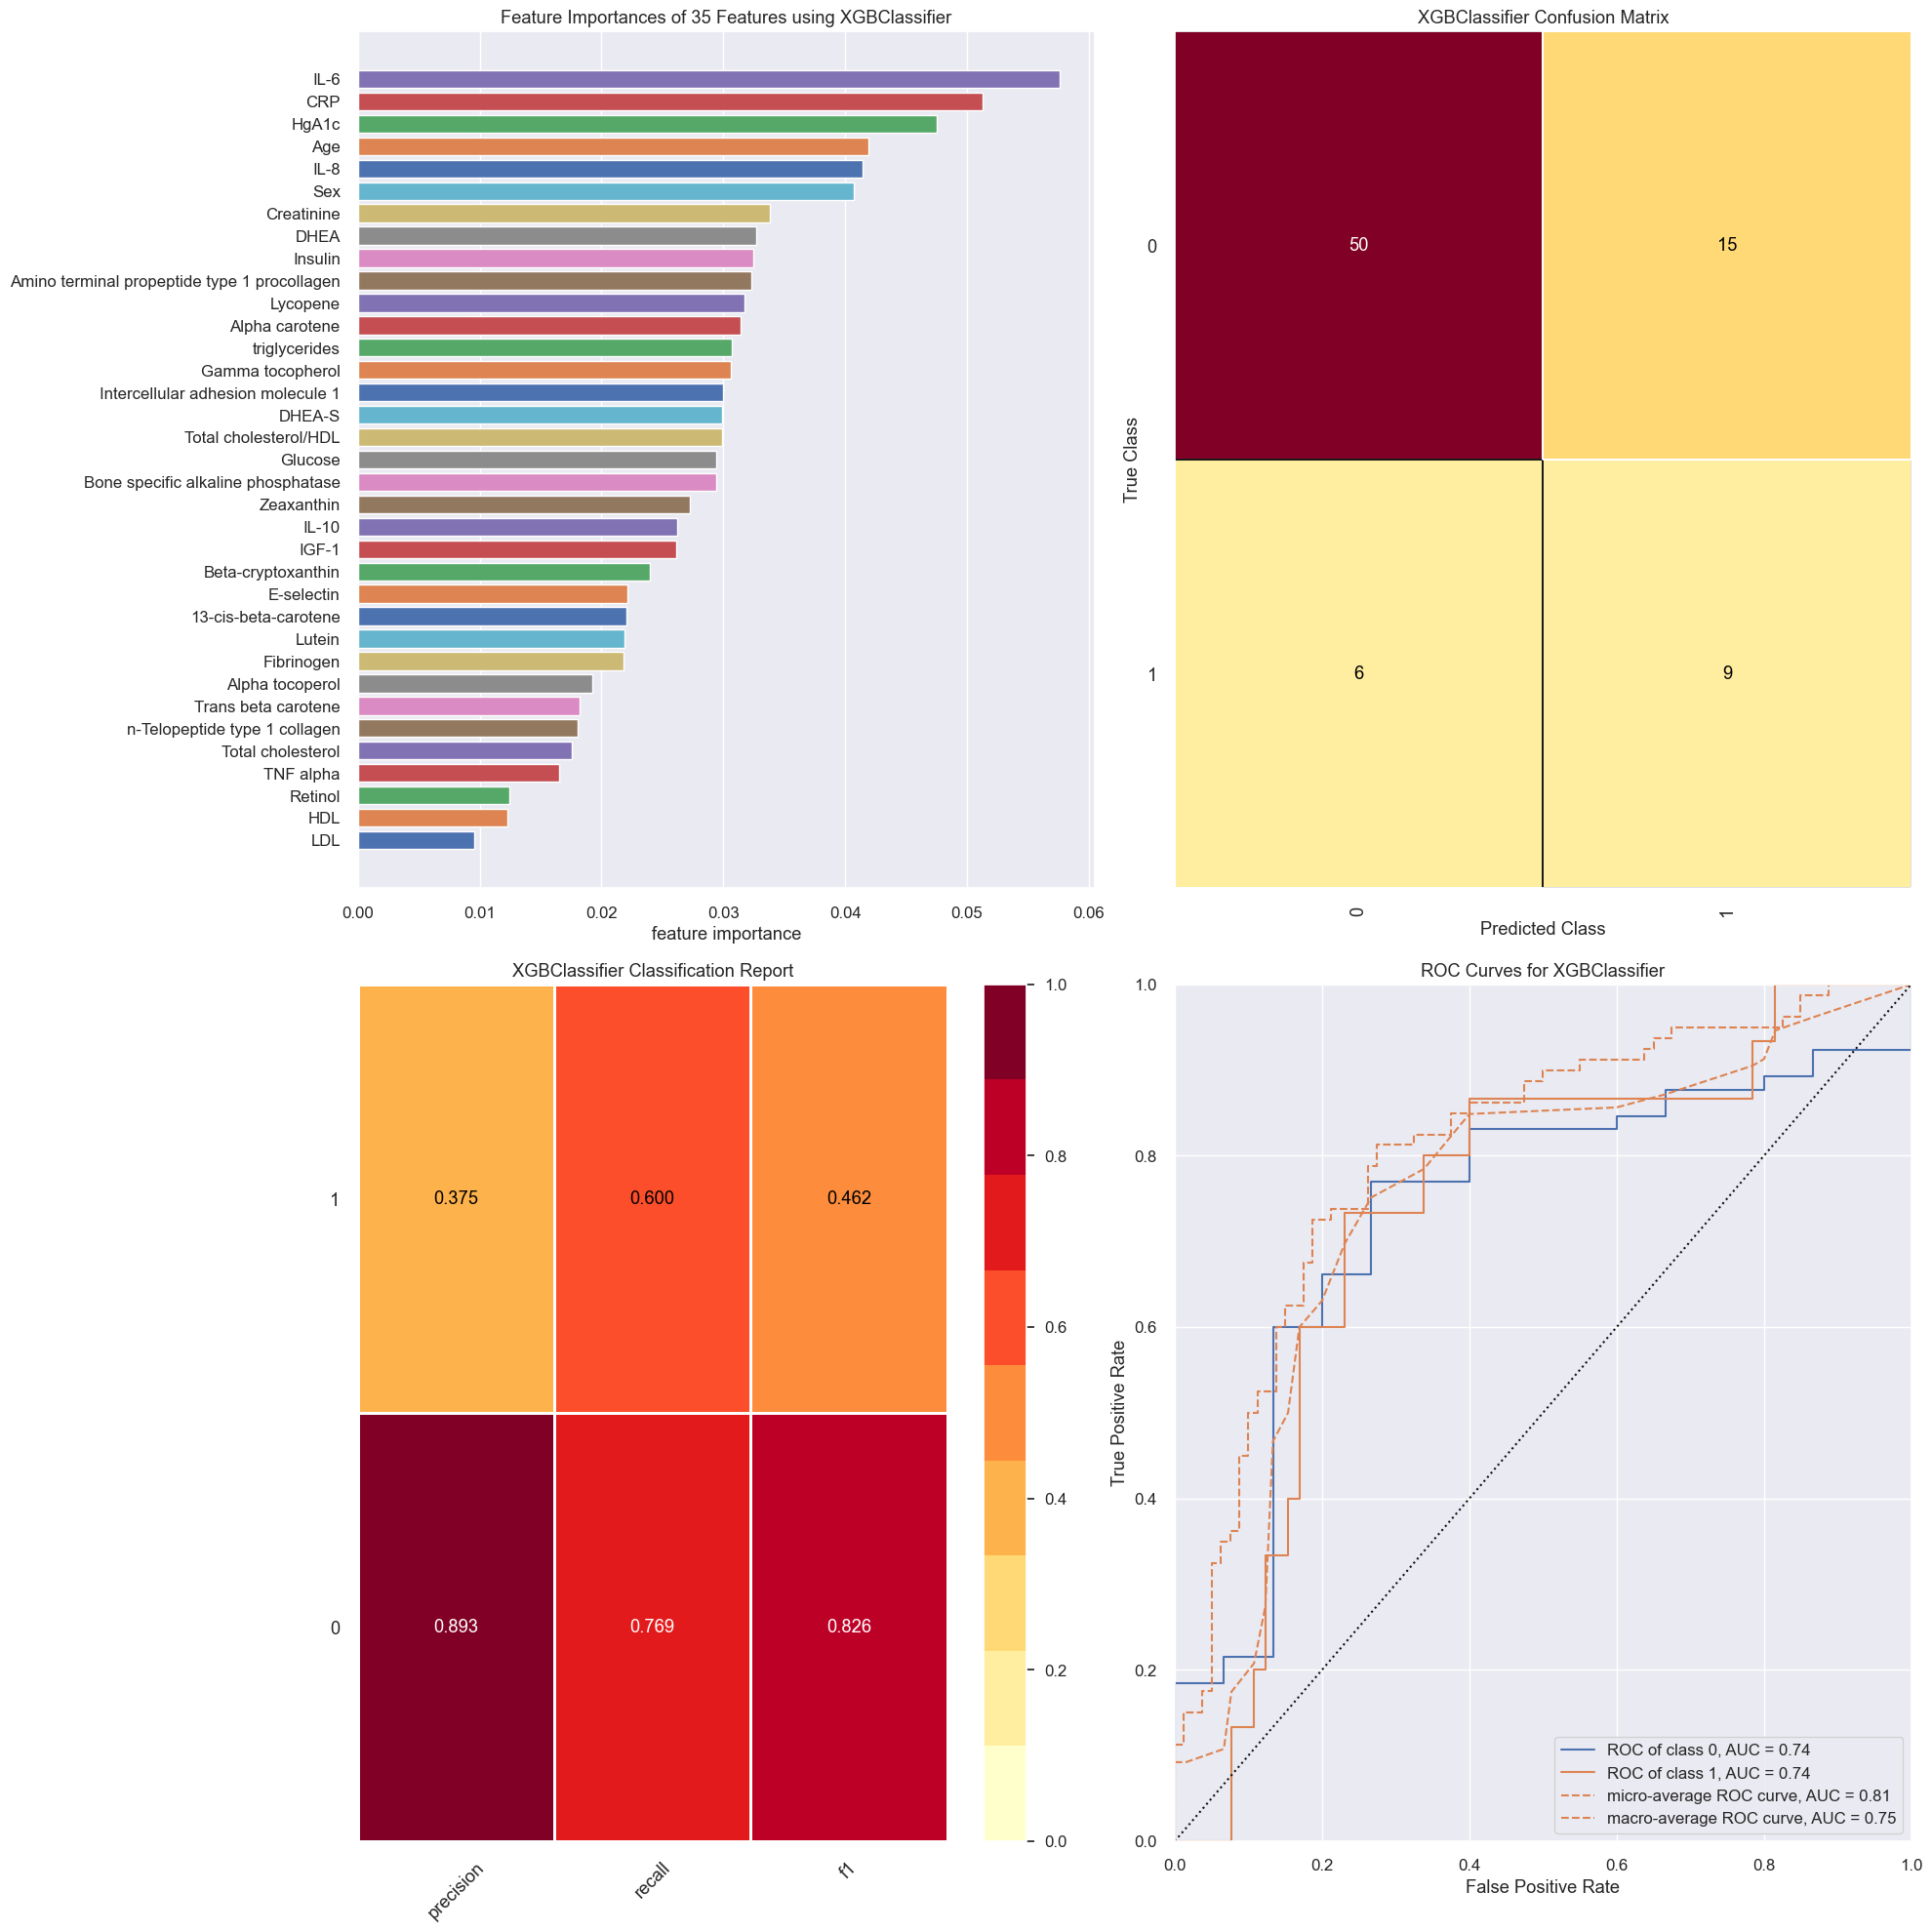

In [1305]:
#yellowbrick is a good library for model evaluation visualizations
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC



fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = pipe_xgb1

pipe_xgb1.named_steps['xgb_tunned'].importance_type = 'gain'

visualgrid = [
    FeatureImportances(pipe_xgb1.named_steps['xgb_tunned'], absolute = True, relative=False, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()


<a id = "10"></a><br>
## Step 2: Feature Selection Based on Model Importance Scores

The above feature importance plot shows importance levels of features based on gain. Gain is defined as the improvement in accuracy brought by a feature to the branches it is on[https://xgboost.readthedocs.io/en/stable/R-package/discoverYourData.html]. 

We can see that some of the features have higher contribution on decision process while some of them less. We have a small data set with relatively high number of columns (399 samples with 35 columns in train set). This problem known as Curse of Dimensionality. It is very likely that less informative features are resulting overfitting. To asses this fenomena we will apply feature selection. There are many feature selection techniques. SelectFromModel() method from scikit-learn's feature selection module is used for feature selection. This method selects features based on model's importance scores (above importance plot). During feature selection proses, starting from most important feature in every iteration the next important feature is added and cross validation is repeated with the based model hyperparameters. The highest cross-validation score is optained with six highest important features. 

The following code block demostrates this work.

In [1306]:

%%time


for i in range(1,36):


    # Create a pipeline for feature selection
    pipeline = imbpipeline([
        ('preprocessor', preprocessor),
         ('smote', sm),
        ('selector', SelectFromModel(xgb_tunned1, threshold=-np.inf, max_features= i)),
        ('classification',xgb_tunned1)
    ])


    # Cross-validation scores with different number of features
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')  #cross-validation
    print("Number of selected features:", i)
    print("Mean CV Score: {:.4f}".format(np.mean(cv_scores)))


Number of selected features: 1
Mean CV Score: 0.3139
Number of selected features: 2
Mean CV Score: 0.3100
Number of selected features: 3
Mean CV Score: 0.3493
Number of selected features: 4
Mean CV Score: 0.3838
Number of selected features: 5
Mean CV Score: 0.3959
Number of selected features: 6
Mean CV Score: 0.4051
Number of selected features: 7
Mean CV Score: 0.4050
Number of selected features: 8
Mean CV Score: 0.3997
Number of selected features: 9
Mean CV Score: 0.3990
Number of selected features: 10
Mean CV Score: 0.3986
Number of selected features: 11
Mean CV Score: 0.3989
Number of selected features: 12
Mean CV Score: 0.3905
Number of selected features: 13
Mean CV Score: 0.3913
Number of selected features: 14
Mean CV Score: 0.3927
Number of selected features: 15
Mean CV Score: 0.3866
Number of selected features: 16
Mean CV Score: 0.3948
Number of selected features: 17
Mean CV Score: 0.3932
Number of selected features: 18
Mean CV Score: 0.3901
Number of selected features: 19
Mean 

Selecting 6 features yiels best CV score.

In [1307]:
%%time


# Cv method

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

# Create a pipeline for feature selection
pipeline = imbpipeline([
    ('preprocessor', preprocessor),
     ('smote', sm),
    ('selector', SelectFromModel(xgb_tunned1, threshold=-np.inf, max_features= 6)),
    ('classification',xgb_tunned1)
])

# Fit the pipeline on the training data to select features
pipeline.fit(X_train, y_train)

CPU times: total: 5.45 s
Wall time: 447 ms


Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('smote', SMOTE(random_state=10)),
                ('selector',
                 SelectFromModel(estimator=XGBClassifier(alpha=0.000402612165325408,
                                                         base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=0.6230940284871702,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=...
                               gpu_id=None, grow_policy=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.005497165288965543, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=8, missing=nan,
                               monotone_constraints=None, n_estimators=376,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [1308]:
#Prints out selected and eleminated features
selected_features = np.array( preprocessor.get_feature_names_out())[pipeline.named_steps['selector'].get_support()]

print("Number of selected features:", len(selected_features))

print("_______________________________")

print("Selected features:", selected_features)


print("_______________________________")

print("Dropped features:", list(set(X_train.columns) - set(selected_features)))



Number of selected features: 6
_______________________________
Selected features: ['HgA1c' 'IL-6' 'IL-8' 'CRP' 'Age' 'Sex']
_______________________________
Dropped features: ['Insulin', 'Total cholesterol/HDL', 'DHEA-S', 'Trans beta carotene', 'triglycerides', 'Zeaxanthin', 'Fibrinogen', 'TNF alpha', 'Alpha tocoperol', 'Total cholesterol', 'Creatinine', 'Amino terminal propeptide type 1 procollagen', 'DHEA', 'LDL', 'Lutein', 'Glucose', 'Intercellular adhesion molecule 1', 'Bone specific alkaline phosphatase', 'Retinol', '13-cis-beta-carotene', 'Gamma tocopherol', 'IL-10', 'Beta-cryptoxanthin', 'IGF-1', 'Lycopene', 'E-selectin', 'HDL', 'n-Telopeptide type 1 collagen', 'Alpha carotene']


In [1309]:
# Reduce feature set to selected ones
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [1310]:
# Report Cross-validation score with selected features
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='f1')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.427
Test Score: 0.526


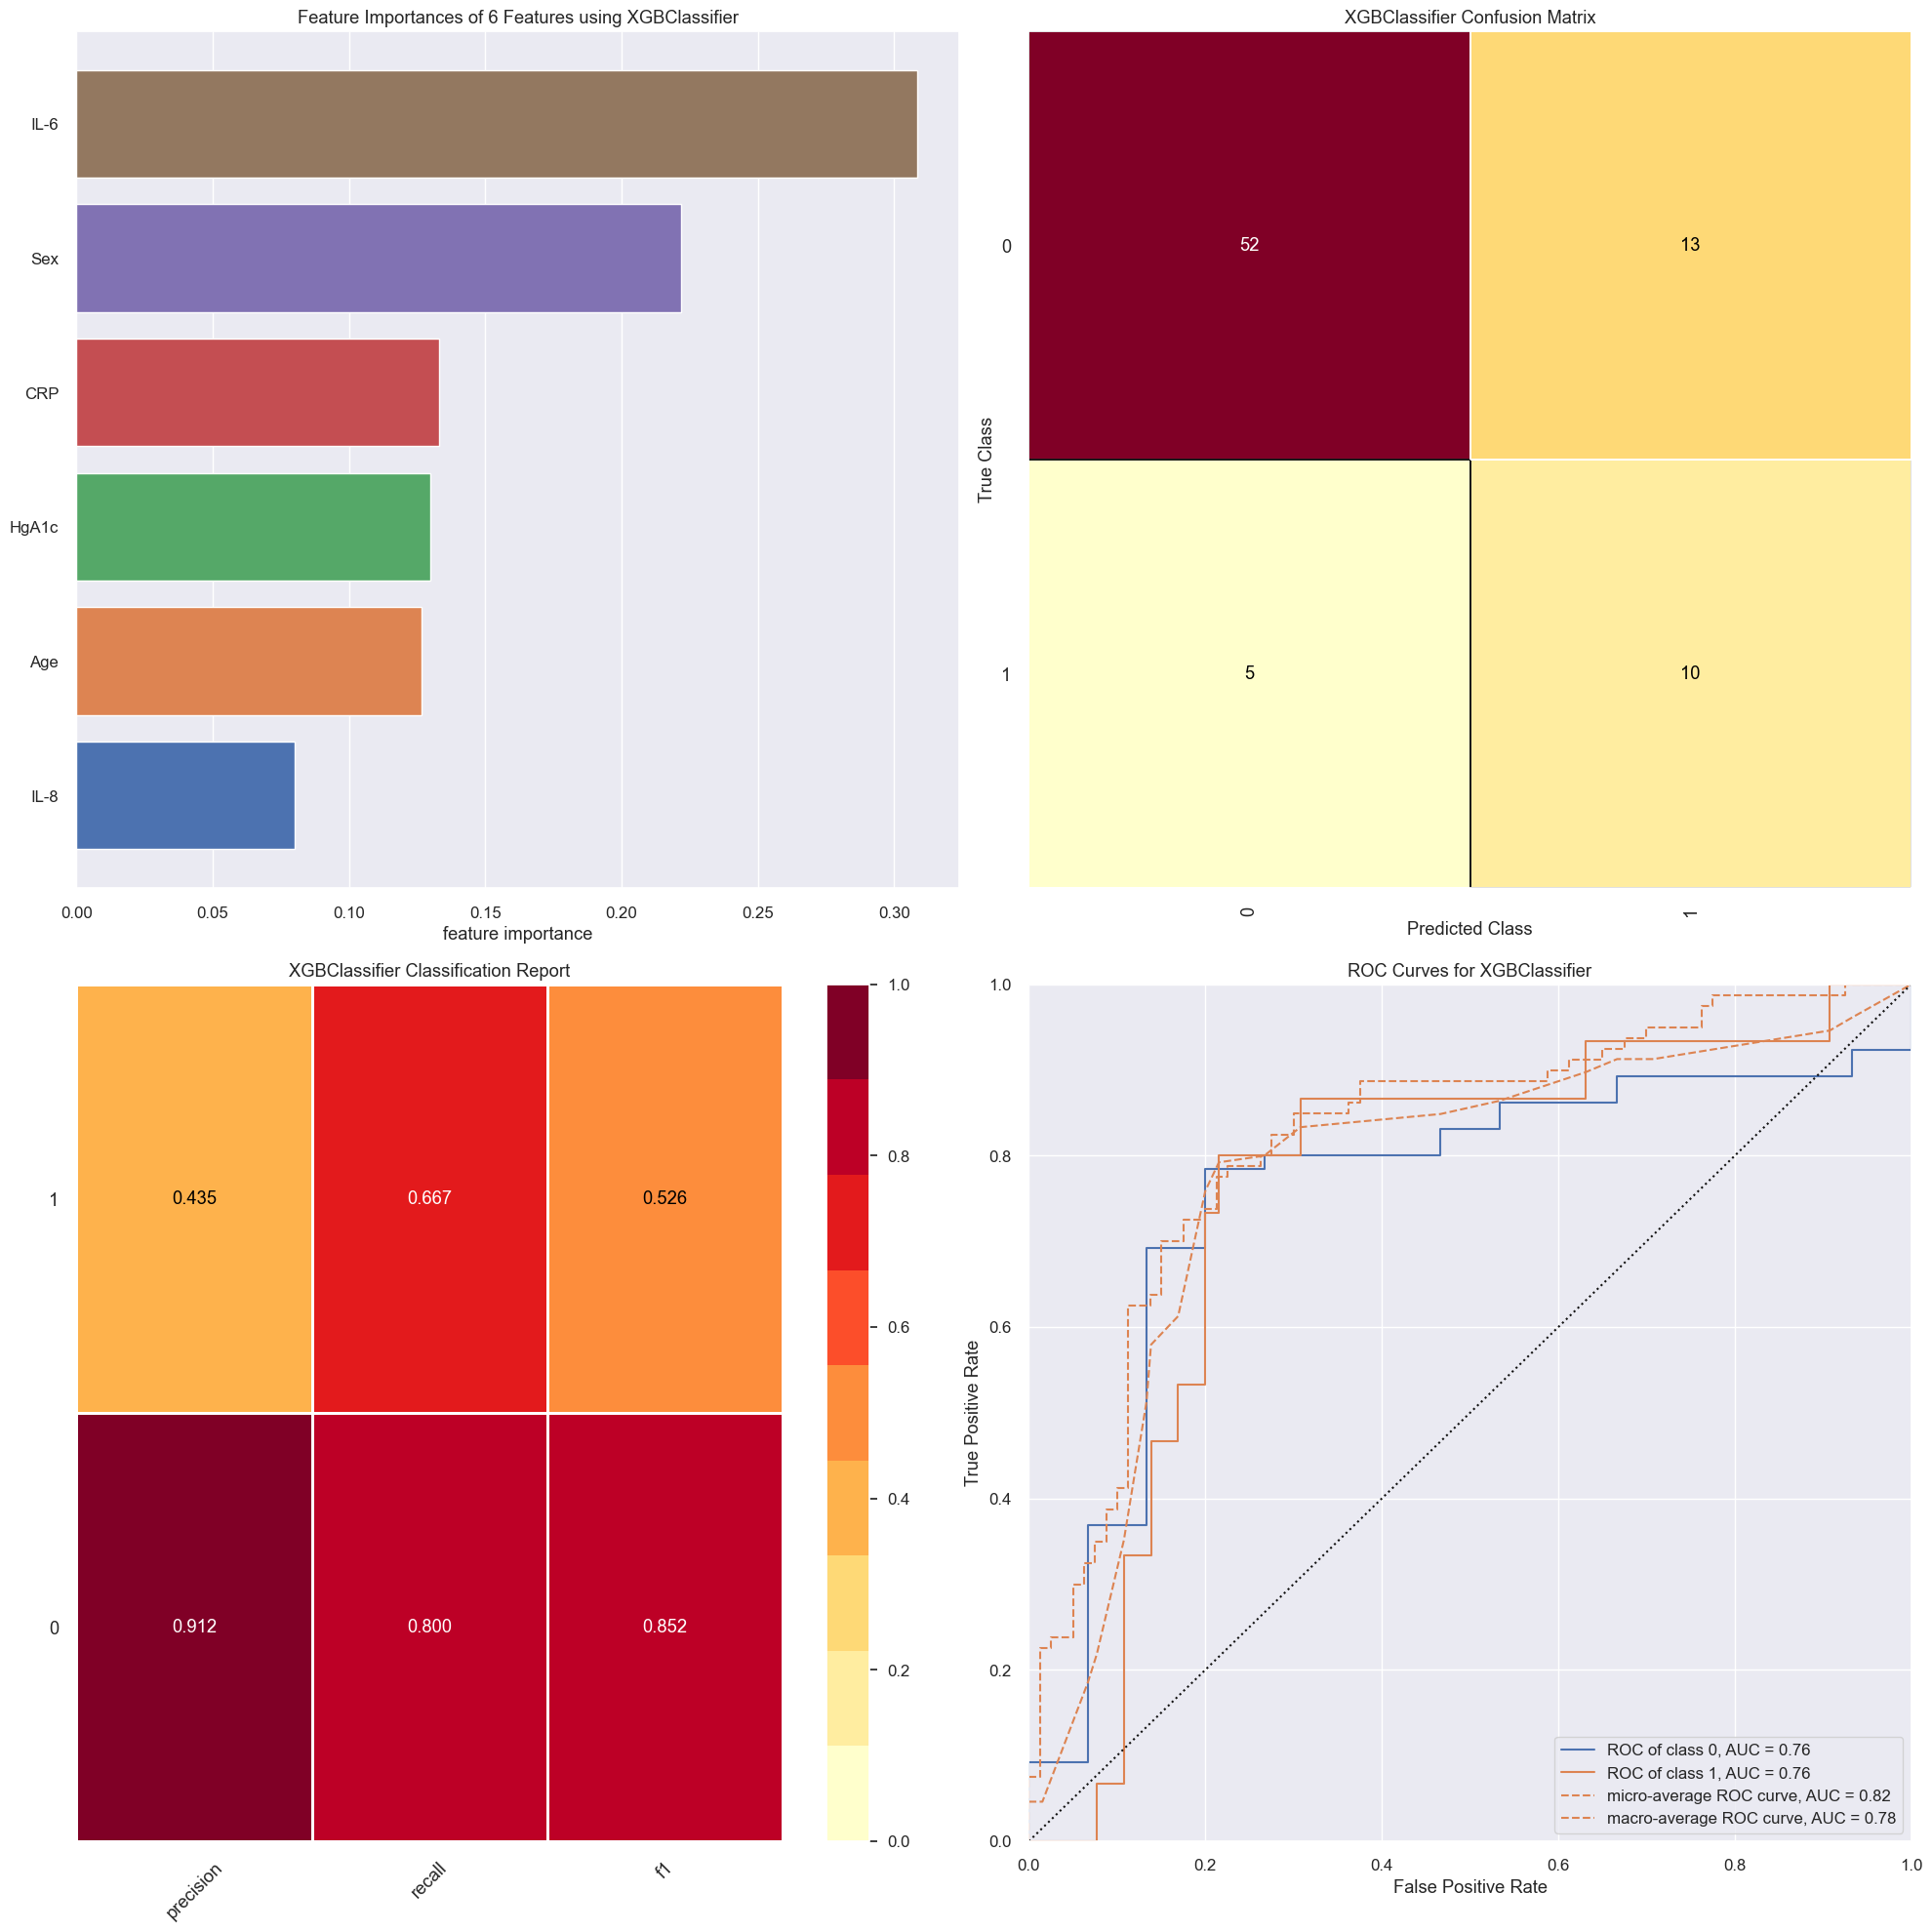

In [1311]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = pipe_xgb1

pipe_xgb1.named_steps['xgb_tunned'].importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(pipe_xgb1.named_steps['xgb_tunned'], absolute = True, relative=False, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train_selected, y_train)
    viz.score(X_test_selected, y_test)
    viz.finalize()

plt.show()


* With the selected features we have a better CV score of 0.427. Before feature selection it was 0.399.

* We get a significant performance increase just eleminating unnnecesary features. 

* Remember that this is still our base model It's hyperparameters are selected based on all features

Let's repeat hyperparameter optimization with selected features.

<a id = "11"></a><br>
## Step 3: Hyperparameter tunning with selected features

Following code block performs hyperparameter tunning only with selected features.

In [1312]:
#xgboost

  

#def objective(trial):

#    n_estimators = trial.suggest_int("n_estimators", 10,500)
    # L1 regularization weight.
#    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
#    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.8)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth = trial.suggest_int("max_depth", 3, 12)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    # learning rate
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
    # defines how selective algorithm is.
#    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    

       

#    xgb_clf = XGBClassifier(n_estimators = n_estimators,alpha=alpha,subsample=subsample,colsample_bytree=colsample_bytree,
#                           max_depth=max_depth,min_child_weight =min_child_weight,learning_rate=learning_rate,gamma=gamma,
#                           random_state =random_state)
   
        
     # -- Make a pipeline
#    xgb_pipeline = imbpipeline([
    
#    ('preprocessor', preprocessor),
#    ('smote', sm),
#    ("xgb_clf", xgb_clf)
#    ])
    
#    ss = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state) #Cross validation strategy
#    score = cross_val_score(xgb_pipeline, X_train_selected, y_train, scoring= make_scorer(f1_score),  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=300)

The above code suggest best hyperparameters as following with a cross validation f1 score 0.461.

{'n_estimators': 422, 'alpha': 0.00025316727636985045, 'subsample': 0.2625265855043195,'colsample_bytree': 0.22066847706109496, 'max_depth': 6, 'min_child_weight': 9, 'learning_rate': 0.0003133276734497596, 'gamma': 1.468816194758717e-06}

I will repeat cross validation with the found hyperparameters for demostration of findings.

In [1313]:
xgb_optuna_params1 =  {'n_estimators': 422, 'alpha': 0.00025316727636985045, 'subsample': 0.2625265855043195, 
                       'colsample_bytree': 0.22066847706109496, 'max_depth': 6, 'min_child_weight': 9,
                       'learning_rate': 0.0003133276734497596, 'gamma': 1.468816194758717e-06}

# Model pipeline with found hyperparameters
xgb_tunned1 = XGBClassifier(**xgb_optuna_params1, random_state=random_state)

pipe_xgb1 =imbpipeline([
    
    ('preprocessor', preprocessor),
     ('smote', sm),
    ("xgb_tunned", xgb_tunned1)
])

pipe_xgb1

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('smote', SMOTE(random_state=10)),
                ('xgb_tunned',
                 XGBClassifier(alpha=0.00025316727636985045, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.22066847706109496,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=No...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0003133276734497596,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=9,
                               missing=nan, monotone_constraints=None,
                               n_estimators=422, n_jobs=None,
                               num_parallel_tree=None, predictor=None, ...))])

In [1314]:
# F1 Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='f1')  #cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.461
Test Score: 0.537


The CV score for base model with selected features was  0.427. 

CV score is increased to 0.461 after hyperparameter tunning with selected features. This will be our final model. Let's also report CV scores of other metrics for this final model.

In [1315]:
# Accuracy Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='accuracy')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(accuracy_score(y_test, preds_test)))

Mean CV Score: 0.708
Test Score: 0.762


In [1316]:
# AUC Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='roc_auc')  #cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict_proba(X_test_selected)[:, 1]
print("Test Score: {:.3f}".format(roc_auc_score(y_test, preds_test)))

Mean CV Score: 0.739
Test Score: 0.754


In [1317]:
# Recall Cross-validation score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='recall')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(recall_score(y_test, preds_test)))

Mean CV Score: 0.683
Test Score: 0.733


In [1318]:
# Specificity Cross-validation score (please notice pos_label=0 on recall score)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring=specificity)  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(recall_score(y_test, preds_test, pos_label=0)))

Mean CV Score: 0.714
Test Score: 0.769


In [1319]:
# Cross-validation scores
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

cv_scores = cross_val_score(pipe_xgb1, X_train_selected, y_train, cv=cv, scoring='precision')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
pipe_xgb1 = pipe_xgb1.fit(X_train_selected, y_train)
preds_test = pipe_xgb1.predict(X_test_selected)
print("Test Score: {:.3f}".format(precision_score(y_test, preds_test)))

Mean CV Score: 0.351
Test Score: 0.423


Let's plot model performance summary on test set and feature importances one last time.

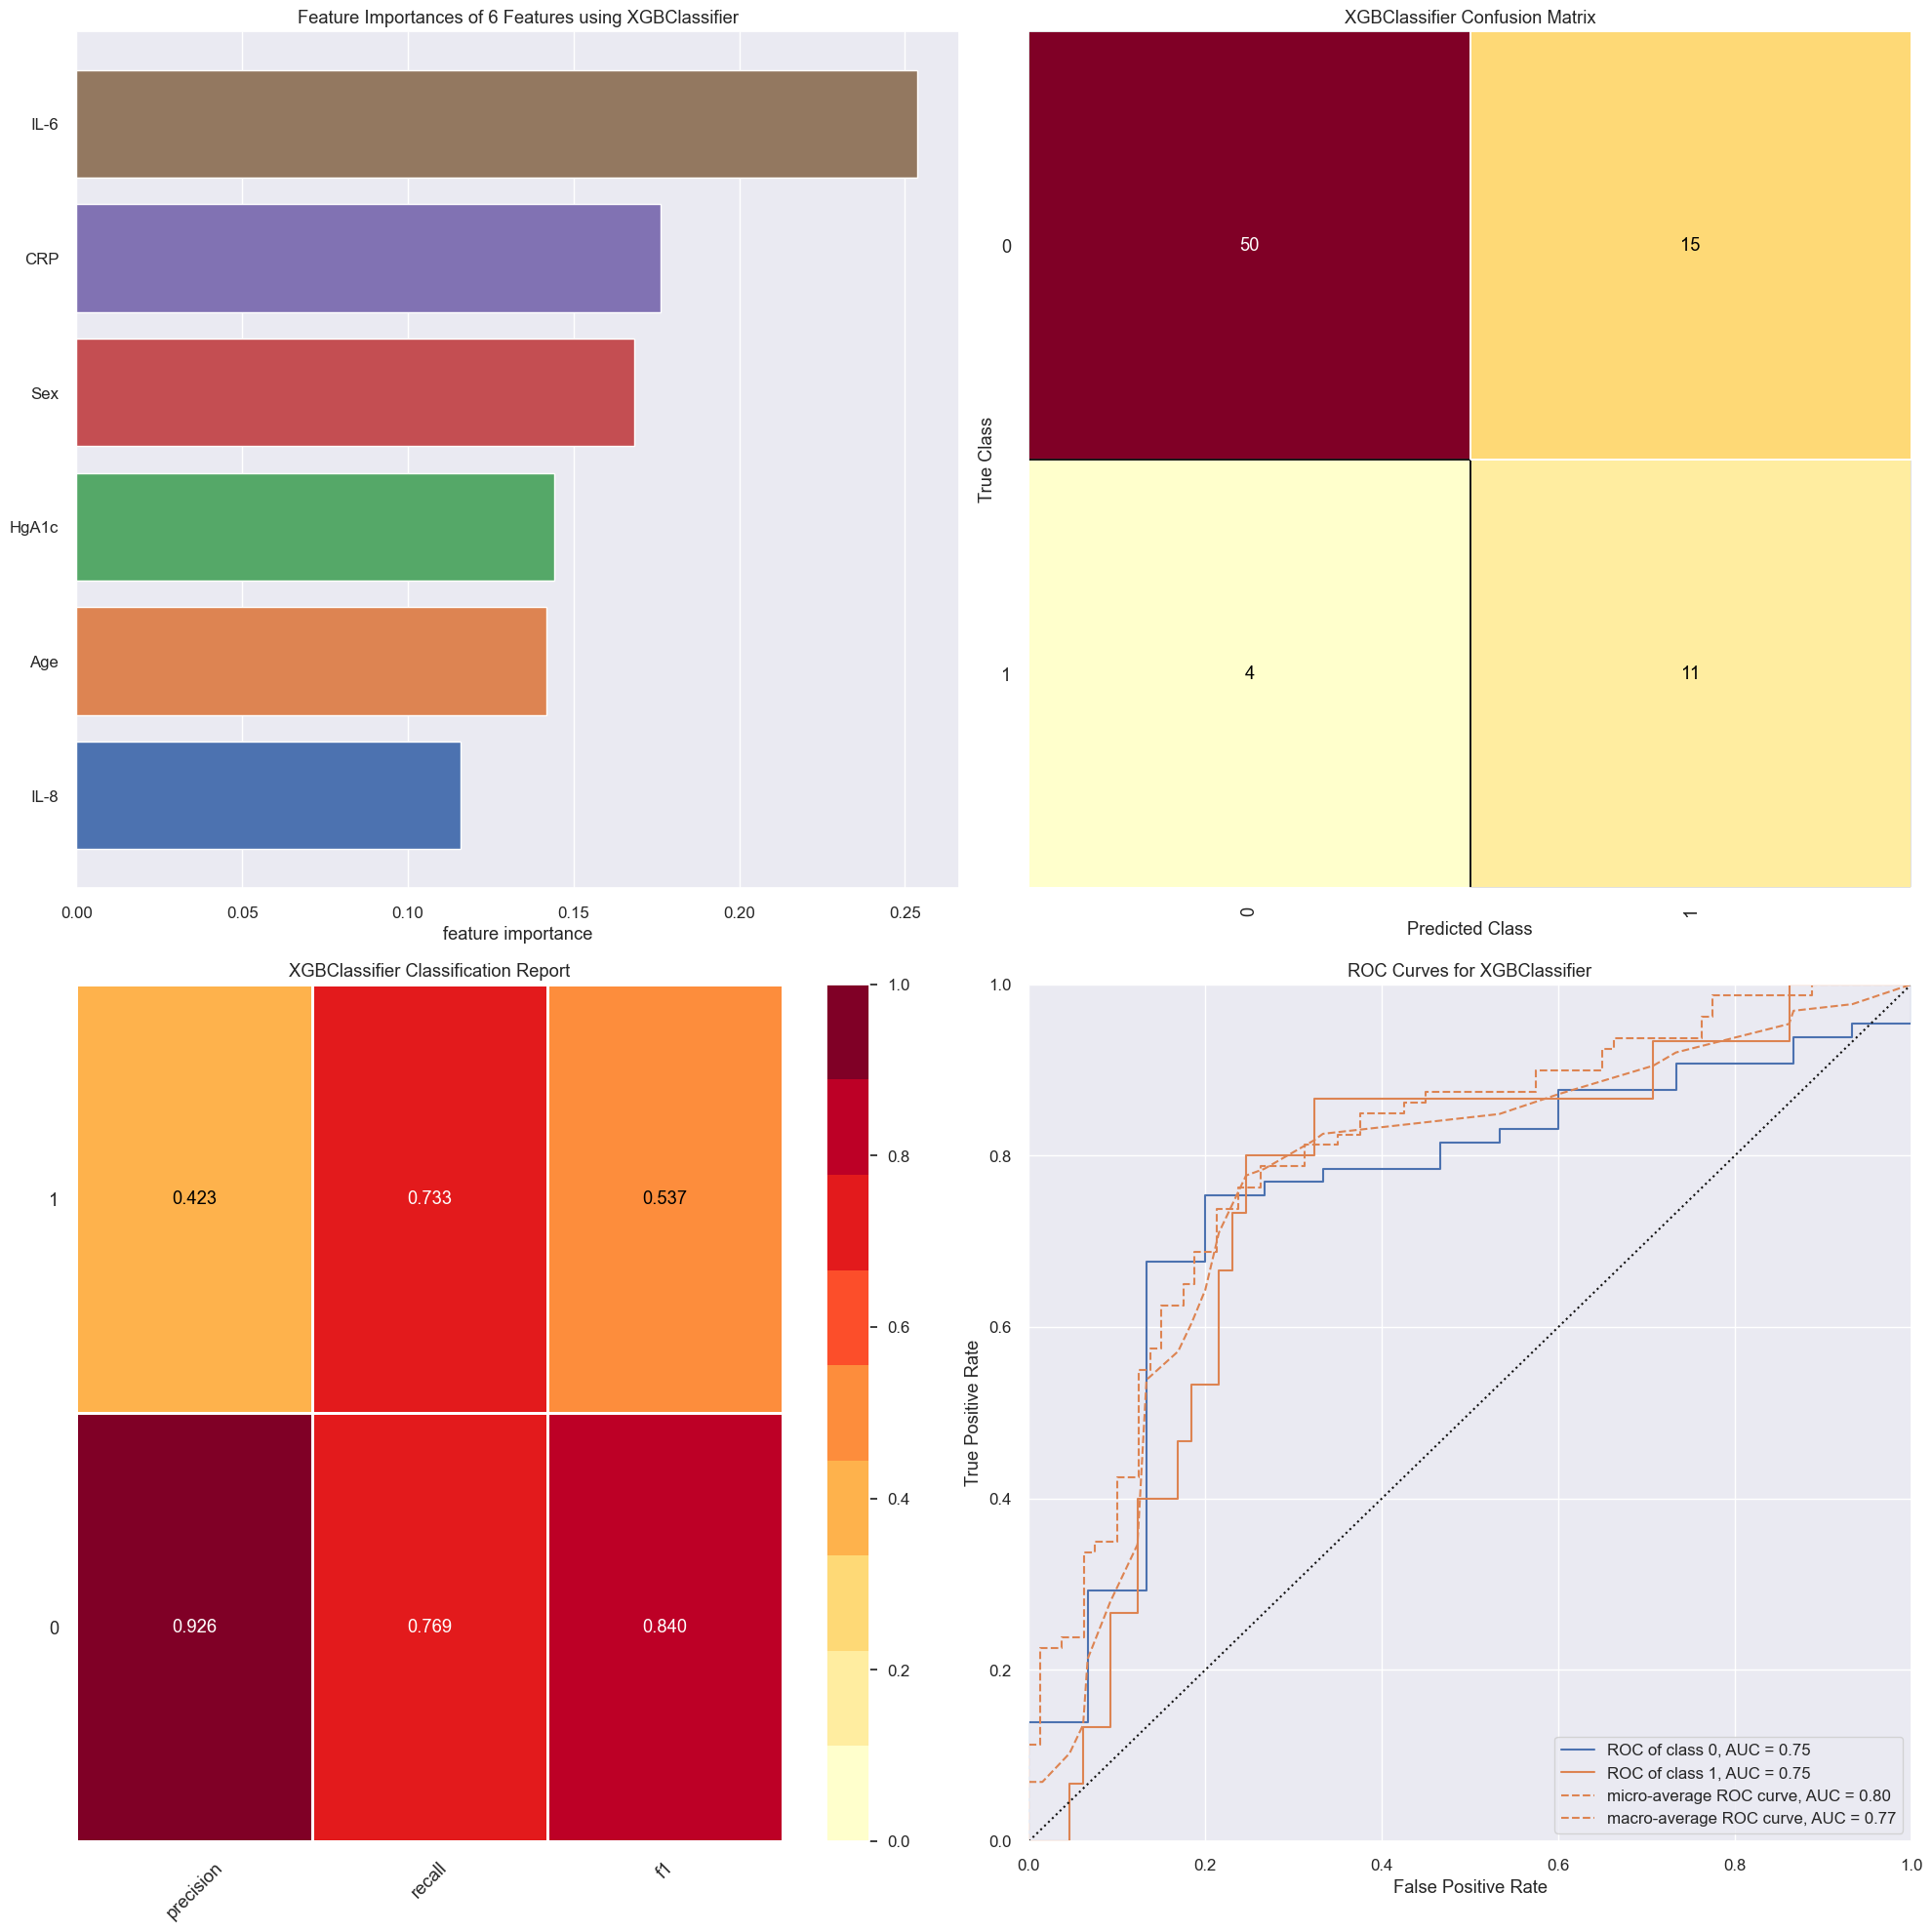

In [1320]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = pipe_xgb1

pipe_xgb1.named_steps['xgb_tunned'].importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(pipe_xgb1.named_steps['xgb_tunned'], absolute = True, relative=False, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train_selected, y_train)
    viz.score(X_test_selected, y_test)
    viz.finalize()

plt.show()


<a id = "12"></a><br>
## Explainable ML with SHAP

Another usefull tool for explaining machine learning models is Shapley values. Shapley values are a widely used approach from  game theory. They help Shapley-based explanations of machine learning models. 

For more information you can check: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

Lastly I want to report SHAP based feature importances.

In [1321]:
#pip install shap

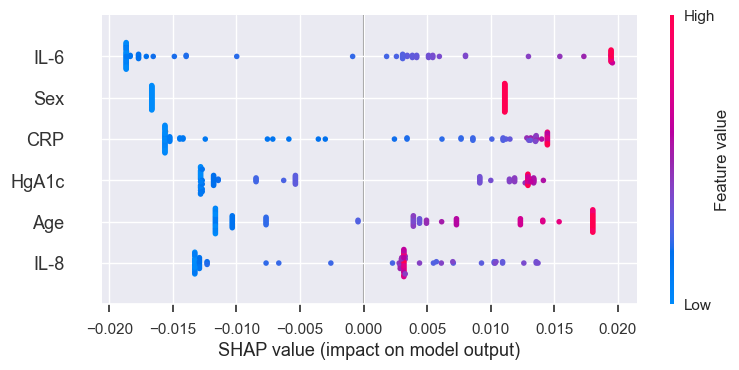

In [1334]:
import shap

explainer = shap.TreeExplainer(pipe_xgb1.named_steps['xgb_tunned'], data=X_train_selected, feature_perturbation='interventional')


shap_values = explainer.shap_values(X_test_selected)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test_selected)

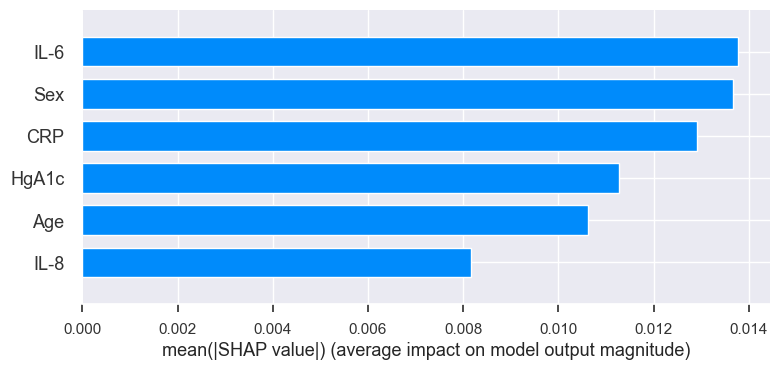

In [1359]:
shap.summary_plot(shap_values, X_test_selected, plot_type = 'bar')